# Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

## Optativa: Series de Tiempo en Finanzas

### Examen de Media Materia

Grupo A13: _Emanuel Nicolás Herrador_

---


## 0. Índice


- [1. Introducción](#1-introducción)
- [2. Desarrollo previo](#2-desarrollo-previo)
- [3. Demanda eléctrica en Victoria](#3-demanda-eléctrica-en-victoria)
  - [3.1. Carga y descripción de los datos](#31-carga-y-descripción-de-los-datos)
  - [3.2. Transformación primaria de los datos](#32-transformación-primaria-de-los-datos)
  - [3.3. Estudio de la demanda mensual (_Problema 1_)](#33-estudio-de-la-demanda-mensual-problema-1)
    - [3.3.1. Cálculo de datos mensuales](#331-cálculo-de-datos-mensuales)
    - [3.3.2. Gráfico de Radar](#332-gráfico-de-radar)
    - [3.3.3. Gráfico de Barra Circular](#333-gráfico-de-barra-circular)
    - [3.3.4. Gráfico de Ploteo Radial](#334-gráfico-de-ploteo-radial)
    - [3.3.5. Conclusión de la visualización](#335-conclusión-de-la-visualización)
- [4. Polución en Madrid](#4-polución-en-madrid)
  - [4.1. Carga y descripción de los datos](#41-carga-y-descripción-de-los-datos)
  - [4.2. Transformación primaria de los datos](#42-transformación-primaria-de-los-datos)
  - [4.3. Descomposición de las mediciones (_Problema 2_)](#43-descomposición-de-las-mediciones-problema-2)
    - [4.3.1. Primera vista y funciones auxiliares](#431-primera-vista-y-funciones-auxiliares)
    - [4.3.2. Descomposición mensual de `NO_2`](#432-descomposición-mensual-de-no_2)
    - [4.3.3. Descomposición mensual de `CO`](#433-descomposición-mensual-de-co)
    - [4.3.4. Conclusiones de la descomposición](#434-conclusiones-de-la-descomposición)
  - [4.4. Suavizado y predicción del comportamiento de los gases (_Problema 3_)](#44-suavizado-y-predicción-del-comportamiento-de-los-gases-problema-3)
    - [4.4.1. Funciones auxiliares a utilizar](#441-funciones-auxiliares-a-utilizar)
    - [4.4.2. Suavizado con el entrenamiento y predicción del test para `NO_2`](#442-suavizado-con-el-entrenamiento-y-predicción-del-test-para-no_2)
    - [4.4.3. Suavizado con el entrenamiento y predicción del test para `CO`](#443-suavizado-con-el-entrenamiento-y-predicción-del-test-para-co)
    - [4.4.4. Predicción a futuro](#444-predicción-a-futuro)
- [5. Conclusiones finales del trabajo](#5-conclusiones-finales-del-trabajo)


## 1. Introducción


El presente trabajo consiste en el uso de técnicas de visualización, descomposición y suavizamiento de series temporales con el objetivo de mostrar el uso que se le puede dar a ellas.

Puntualmente usaremos:

- Demanda eléctrica en Victoria (2012-2014) para realizar la visualización
- Polución en Madrid, España (2001-2019) para usar descomposición, suavizamiento y predecir el comportamiento de los gases `NO_2` y `CO`.

Para ello, a continuación se resolverá cada uno de los problemas planteados por la cátedra con su respectiva explicación, con comentarios y conclusiones. Para que sea de forma más ordenada, se separará el trabajo en dos partes: una por cada conjunto de datos.


## 2. Desarrollo previo


Lo primero que vamos a hacer antes de comenzar a resolver los problemas planteados, es importar las librerías.


In [1]:
import pandas as pd
import numpy as np
import os

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from PIL import Image
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error

# Para reproducibilidad e ignorar warnings
import warnings
warnings.filterwarnings("ignore")
np.random.seed(0)

## 3. Demanda eléctrica en Victoria


### 3.1. Carga y descripción de los datos


Tenemos una serie temporal con la demanda eléctrica (MW) del estado de Victoria (Australia) desde el 2011-12-31 al 2014-12-31. El set de datos contiene $5$ columnas y $52608$ registros completos (sin valores nulos).

La información que representa cada columna es:

- _Time_: Fecha y hora del registro.
- _Date_: Fecha del registro.
- _Demand_: Demanda de electricidad MW.
- _Temperature_: Temperatura en Melbourne (capital de Victoria).
- _Holiday_: Indicador si el día es de vacaciones.

Podemos ver esta información a continuación:


In [2]:
VICTORIA = pd.read_csv('./data/vic_elec.csv')
VICTORIA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52608 entries, 0 to 52607
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         52608 non-null  object 
 1   Demand       52608 non-null  float64
 2   Temperature  52608 non-null  float64
 3   Date         52608 non-null  object 
 4   Holiday      52608 non-null  bool   
dtypes: bool(1), float64(2), object(2)
memory usage: 1.7+ MB


### 3.2. Transformación primaria de los datos


Una vez cargados los datos, notaremos que tenemos dos columnas de tipo _String_ que representan temporalidad: `Time` y `Date`, lo cual es redundante.


In [3]:
VICTORIA.head()

Time       Demand  Temperature        Date  Holiday
0  2011-12-31T13:00:00Z  4382.825174        21.40  2012-01-01     True
1  2011-12-31T13:30:00Z  4263.365526        21.05  2012-01-01     True
2  2011-12-31T14:00:00Z  4048.966046        20.70  2012-01-01     True
3  2011-12-31T14:30:00Z  3877.563330        20.55  2012-01-01     True
4  2011-12-31T15:00:00Z  4036.229746        20.40  2012-01-01     True

Por este motivo, dado que `Time` tiene, obviamente, mayor precisión, decidimos quedarnos con este. Algo a tener en cuenta para ello es que esta columna contiene los datos espaciados cada $30$ minutos.


In [4]:
# Eliminamos la columna Date
df_vic = VICTORIA.drop(columns=['Date'])

# Convertimos la columna Time a formato datetime y la establecemos como índice
df_vic['Time'] = pd.to_datetime(df_vic['Time'], format='%Y-%m-%dT%H:%M:%SZ')
df_vic = df_vic.set_index('Time')
df_vic = df_vic.asfreq('30min')
df_vic = df_vic.sort_index()

# Chequeamos que no haya registros faltantes ni duplicados
is_frec_correct = (df_vic.index == pd.date_range(
    start=df_vic.index[0], periods=len(df_vic), freq=df_vic.index.freq)).all()
assert is_frec_correct, 'Frecuencia incorrecta'

# Mostramos primeros y últimos registros
display(df_vic.head())
display(df_vic.tail())

Demand  Temperature  Holiday
Time                                                  
2011-12-31 13:00:00  4382.825174        21.40     True
2011-12-31 13:30:00  4263.365526        21.05     True
2011-12-31 14:00:00  4048.966046        20.70     True
2011-12-31 14:30:00  3877.563330        20.55     True
2011-12-31 15:00:00  4036.229746        20.40     True

Demand  Temperature  Holiday
Time                                                  
2014-12-31 10:30:00  3873.448714         19.0    False
2014-12-31 11:00:00  3791.637322         18.5    False
2014-12-31 11:30:00  3724.835666         17.7    False
2014-12-31 12:00:00  3761.886854         17.3    False
2014-12-31 12:30:00  3809.414586         17.1    False

Ahora, como Diciembre de 2011 contiene únicamente datos desde la mitad del último día, estos los vamos a sacar para evitar sesgo.


In [5]:
df_vic_2 = df_vic.copy()

# Quedarme solo con las filas con indice con año 2012 en adelante
df_vic_2 = df_vic_2.loc['2012':]

print(f'Se eliminaron {df_vic.shape[0] - df_vic_2.shape[0]} filas')
display(df_vic_2.head())

Se eliminaron 22 filas


Demand  Temperature  Holiday
Time                                                  
2012-01-01 00:00:00  4599.507418         29.1     True
2012-01-01 00:30:00  4772.133542         30.2     True
2012-01-01 01:00:00  4938.795740         31.3     True
2012-01-01 01:30:00  5080.138254         32.0     True
2012-01-01 02:00:00  5211.915476         32.7     True

Finalmente, otra cosa que se va a realizar es transformar el tipo de dato de `Holiday` en número para que nos sea más fácil trabajar con él.


In [6]:
df_vic_2['Holiday'] = df_vic_2['Holiday'].astype('int')

df_vic_2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52586 entries, 2012-01-01 00:00:00 to 2014-12-31 12:30:00
Freq: 30min
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Demand       52586 non-null  float64
 1   Temperature  52586 non-null  float64
 2   Holiday      52586 non-null  int32  
dtypes: float64(2), int32(1)
memory usage: 1.4 MB


### 3.3. Estudio de la demanda mensual (_Problema 1_)


Lo primero que queremos hacer es estudiar la _demanda mensual_ de energía eléctrica en Victoria utilizando los siguientes gráficos:

- Gráfico de radar
- Gráfico de barra circular
- Gráfico de ploteo radial

Por ello mismo, lo primero que vamos a realizar es el cálculo de los datos necesarios para el análisis y, luego, hacer los gráficos.

Además, debemos armar al final un collage con todos los gráficos hechos.


#### 3.3.1. Cálculo de datos mensuales


Teniendo esto en cuenta, entonces, lo primero que vamos a hacer es calcular los datos que necesitamos por cada uno de los meses durante todos los años. Es decir, queremos comparar todos los Enero con Febrero, Marzo, etc.

Por ello mismo, la idea a seguir va a ser calcular dos datasets:

- Uno con los datos en la escala correspondiente al atributo.
- Otro normalizado en porcentaje (respecto a su máximo histórico en alguna hora), para poder comparar las fluctuaciones de las características en forma conjunta.

Además, otra cosa a tener en cuenta es que:

- Demanda y Temperatura se calculan como la media de las medias de los días de cada mes. Es decir, primero agrupamos por `MES-AÑO` usando la media y luego por `MES`.
- Días festivos se calcula como la media de la suma de los días de cada mes. Es decir, primero sumamos todos los días festivos de cada mes registrado (`MES-AÑO`) y luego nos quedamos con el promedio de estos (agrupando por `MES`).


In [7]:
# Calculamos valores máximos posibles
max_values = {
    'Demand': df_vic_2['Demand'].max(),
    'Temperature': df_vic_2['Temperature'].max(),
    'Holiday': 24 * 2 * 30
}

# Agrupamos con datos crudos
df_vic_grouped = df_vic_2.resample('M').agg({
    'Demand': lambda x: x.mean(),
    'Temperature': lambda x: x.mean(),
    'Holiday': lambda x: x.sum()
})
df_vic_grouped = df_vic_grouped.groupby(df_vic_grouped.index.month).mean()

df_vic_grouped.index.name = 'Month'
df_vic_grouped.index = df_vic_grouped.index.map(
    lambda x: pd.to_datetime(str(x), format='%m').strftime('%B'))

print('=========== Con datos crudos ===========')
display(df_vic_grouped)

# Calculamos los porcentajes (respecto al mayor valor posible) para poder compararlos
df_vic_grouped_transformed = df_vic_grouped.copy()

df_vic_grouped_transformed['Demand'] = df_vic_grouped_transformed['Demand'] / \
    max_values['Demand']
df_vic_grouped_transformed['Temperature'] = df_vic_grouped_transformed['Temperature'] / \
    max_values['Temperature']
df_vic_grouped_transformed['Holiday'] = df_vic_grouped_transformed['Holiday'] / \
    max_values['Holiday']

print('=========== Con datos transformados ===========')
display(df_vic_grouped_transformed)

=========== Con datos crudos ===========


Demand  Temperature     Holiday
Month                                          
January    4783.073929    21.652016   90.000000
February   4899.328722    21.834279    0.000000
March      4567.455626    20.021505   71.333333
April      4418.064196    16.578437  120.666667
May        4766.720602    13.972681    0.000000
June       4970.574751    11.491956   48.000000
July       5048.282912    11.294108    0.000000
August     4907.330829    11.884733    0.000000
September  4494.688245    14.397894    0.000000
October    4440.842677    15.496797    0.000000
November   4382.149656    17.631852   48.000000
December   4316.371836    19.239363  110.666667

=========== Con datos transformados ===========


Demand  Temperature   Holiday
Month                                     
January    0.511832     0.501204  0.062500
February   0.524272     0.505423  0.000000
March      0.488759     0.463461  0.049537
April      0.472773     0.383760  0.083796
May        0.510082     0.323442  0.000000
June       0.531896     0.266018  0.033333
July       0.540212     0.261438  0.000000
August     0.525129     0.275110  0.000000
September  0.480972     0.333285  0.000000
October    0.475210     0.358722  0.000000
November   0.468930     0.408145  0.033333
December   0.461891     0.445356  0.076852

Con ello, entonces, podemos proceder a la visualización de los datos para analizar la demanda mensual de energía eléctrica por mes y su relación con la temperatura y las vacaciones.


#### 3.3.2. Gráfico de Radar


Para este punto vamos a usar la función auxiliar que se encuentra a continuación para realizar los gráficos de radar:


In [8]:
def radar_graph(title, df, theta, fill=None, max_value=1):
    fig = go.Figure()

    for r in range(len(df)):
        fig.add_trace(go.Scatterpolar(
            r=df.iloc[r],
            theta=theta,
            fill=fill,
            name=df.index[r]
        ))

    fig.update_layout(
        title=title,
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, max_value]
            )
        ),
        showlegend=True
    )

    return fig

Con ello, entonces, veamos cada una de las características agrupadas por mes:


In [9]:
vic_radar_graph = make_subplots(
    rows=2, cols=2,
    specs=[[{'type': 'polar'}] * 2] * 2,
    horizontal_spacing=0.2
)

for i, col in enumerate(df_vic_grouped.columns):
    df = pd.DataFrame(df_vic_grouped[col]).T
    fig = radar_graph(f'Promedio de "{col}" por mes',
                      df, df.columns, 'toself', max_values[col])
    vic_radar_graph.add_trace(fig.data[0], row=1 + i // 2, col=1 + i % 2)

vic_radar_graph.update_layout(
    height=800, width=800,
    title_text='Promedios mensuales de demanda eléctrica, temperatura y días festivos'
)

vic_radar_graph.write_image('./images/vic_radar_graph.png', engine='orca')

vic_radar_graph.show()

Gracias a lo cual, nuestra primera aproximación sería decir que existe mayor demanda eléctrica en los meses correspondientes al invierno en Victoria (Mayo - Octubre), los cuales son los de menor temperatura (en promedio, entre unos 11 y 16 grados).

Además, otro factor importante es que en el período de mayor consumo eléctrico únicamente Junio es el mes que contiene días festivos (las vacaciones de invierno), mientras que en verano son muchos más: Noviembre, Diciembre, Marzo y Abril (y con una cantidad mucho mayor de días).

Teniendo esto en cuenta, es claro notar que la demanda eléctrica se eleva en invierno producto de las bajas temperaturas y la necesidad de la utilización de calefacción y realización de comida cocinada caliente (utilizando, en algunos casos, aparatos electrónicos para ello). Además, otro punto a destacar es que en invierno, al haber menos días festivos que en verano, es el momento donde los pequeños y medianos consumidores se encuentran gran parte del tiempo en sus espacios (casas o negocios), mientras que en vacaciones existe un margen temporal donde no están activos.

Todo esto sumado hace que el invierno sea el factor clave, según lo observable, para que la demanda eléctrica aumente justo en estas fechas.


Por motivos visuales, a continuación podemos ver los tres gráficos en conjunto para poder notar de mejor manera la relación entre cada una de las variables:


In [10]:
vic_radar_graph_transformed = radar_graph(
    'Promedio de demanda, temperatura y días festivos por mes (normalizados)',
    df_vic_grouped_transformed.T,
    df_vic_grouped_transformed.T.columns
)

vic_radar_graph_transformed.write_image(
    './images/vic_radar_graph_transformed.png', engine='orca')

vic_radar_graph_transformed.show()

#### 3.3.3. Gráfico de Barra Circular


En este punto vamos a realizar los gráficos de Barra Circular para cada una de las variables. Dada su particularidad y característica, no se podrá realizar un gráfico conjunto con todas las variables normalizadas.

Usaremos la siguiente función auxiliar:


In [11]:
def circular_bar_graph(title, df, x):
    palette = sns.color_palette('husl', n_colors=len(df))

    plt.gcf().set_size_inches(10, 10)
    ax = plt.subplot(projection='polar')

    for i in range(len(df)):
        ax.barh(i, df[x][i] * 2 * np.pi, label=x,
                color=palette[i], edgecolor='black')

    ax.set_theta_zero_location('N')
    ax.set_theta_direction(1)
    ax.set_rlabel_position(0)
    ax.set_thetagrids([], labels=[])
    ax.set_rgrids(range(len(df)), labels=df.index)

    # big tam for title
    plt.title(title, size=20, y=1.02)

    return ax

Con ello, podemos graficar los valores obtenidos por mes:


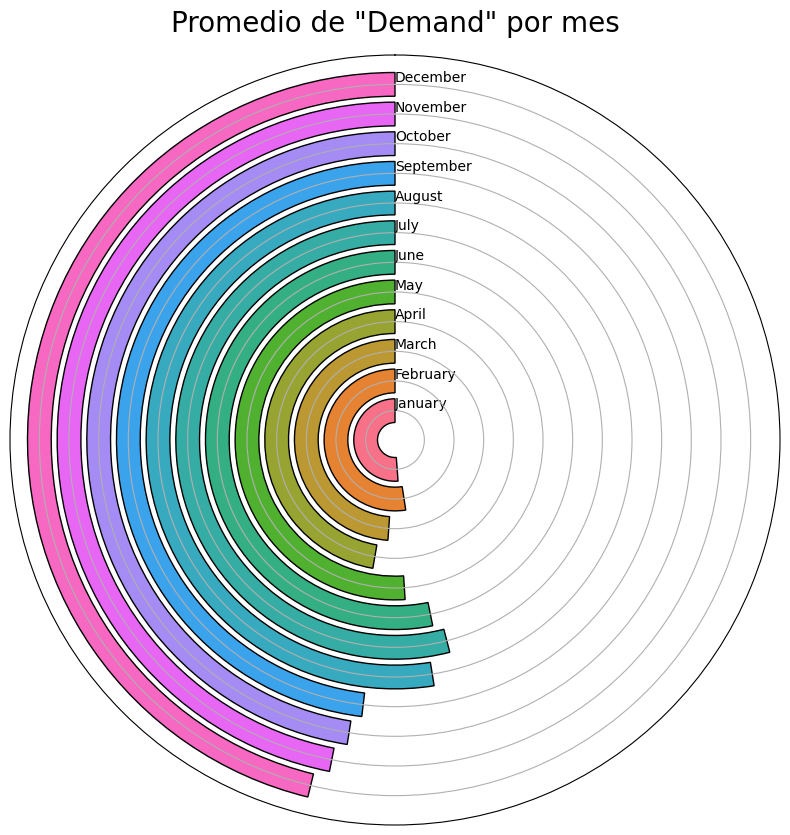

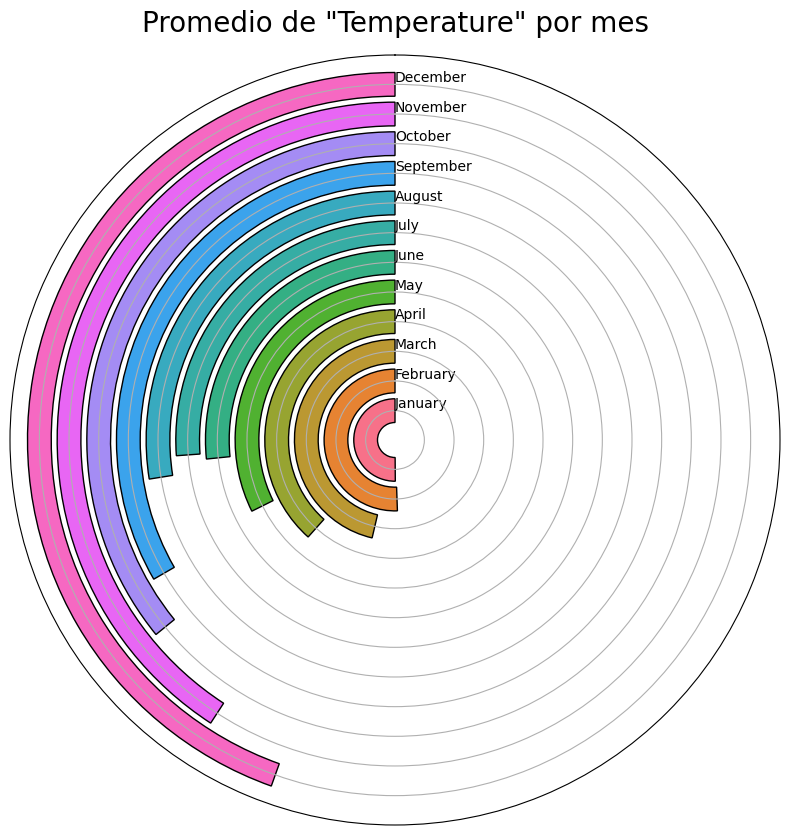

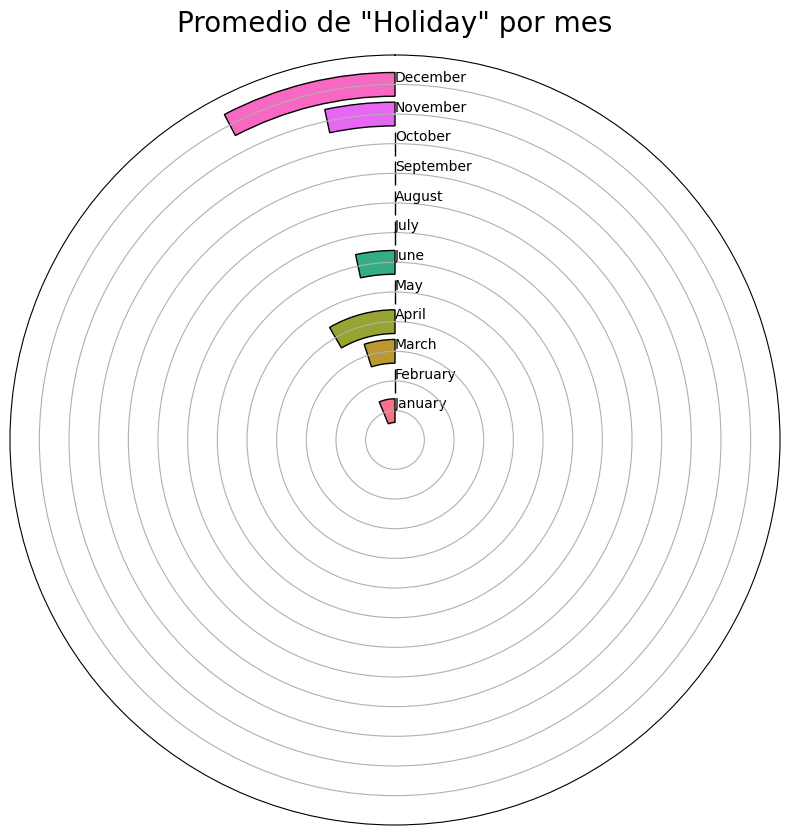

In [12]:
vic_circular_bar_graph = []

for col in df_vic_grouped.columns:
    circular_bar_graph(
        f'Promedio de "{col}" por mes', df_vic_grouped_transformed, col)
    plt.savefig(f'./images/{col}_circular_bar_graph.png')
    vic_circular_bar_graph.append(f'./images/vic_{col}_circular_bar_graph.png')
    plt.show()

Gracias a lo cual notamos exactamente lo mismo que con el gráfico de radar:

- Predominancia de mayor demanda eléctrica durante los meses de invierno (siendo los promedios de Mayo-Agosto mayores al 50% del máximo histórico registrado)
- El hecho de que la mayor demanda eléctrica coincide con las menores temperaturas y fechas con menor cantidad de días festivos/vacaciones.

Sin embargo, por más que podemos hacer este tipo de gráfico, no se considera adecuado en este caso para sacar conclusiones dado que no se pueden tomar en cuenta la relación entre las tres variables en un mismo diagrama.


#### 3.3.4. Gráfico de Ploteo Radial


Por último, el otro tipo de gráfico a realizar es el de ploteo radial.

Al igual que con el caso de la barra circular, se deberá hacer uno por cada característica dado que no se pueden combinar en un mismo gráfico.

Para ello, vamos a usar la siguiente función auxiliar:


In [13]:
def circular_radial_graph(title, df, x):
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111, polar=True)
    plt.axis()

    heights = df[x]
    width = 2 * np.pi / len(df.index)

    idx = list(range(1, len(df.index) + 1))
    angles = [i * width for i in idx]

    bars = ax.bar(angles, heights, width=width, bottom=0.0, linewidth=1,
                  edgecolor='white', color=sns.color_palette('husl', n_colors=len(df)))

    for bar, angle, height, label in zip(bars, angles, heights, df.index):
        rotation = np.rad2deg(angle)
        alignment = ''

        if angle >= np.pi / 2 and angle < 3 * np.pi / 2:
            rotation += 180
            alignment = 'right'
        else:
            alignment = 'left'

        ax.text(x=angle, y=0.0 + bar.get_height() + 2, s=label, ha=alignment,
                va='center', rotation=rotation, rotation_mode='anchor')

        ax.set_thetagrids([], labels=[])
        plt.title(title, size=20, y=1.02)

    return ax

Con ello, entonces, podemos proceder a realizar los gráficos correspondientes para cada una de las variables a considerar:


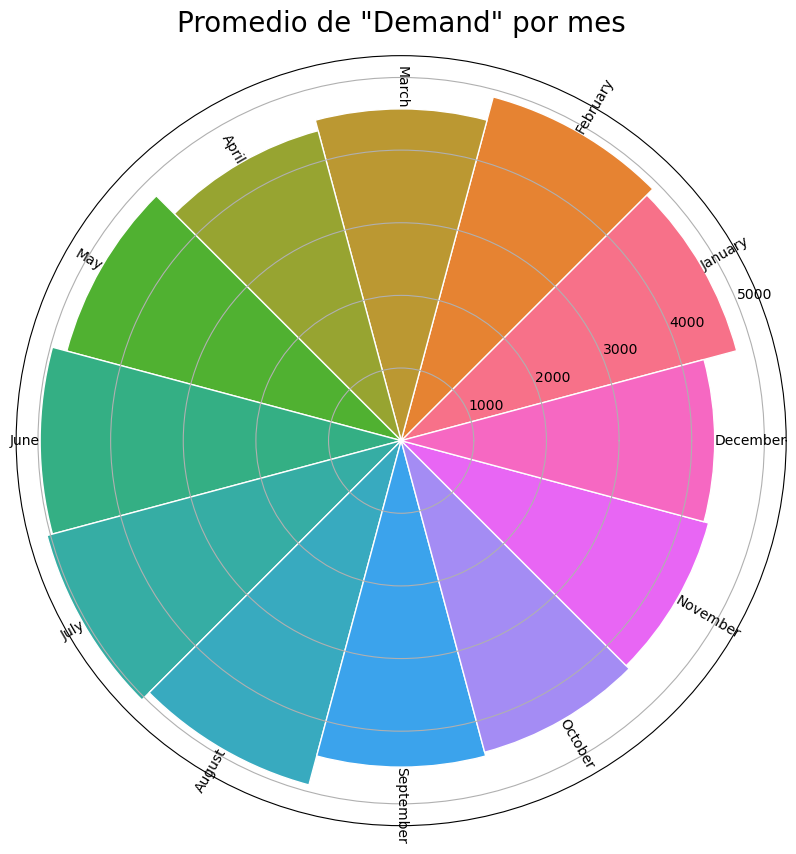

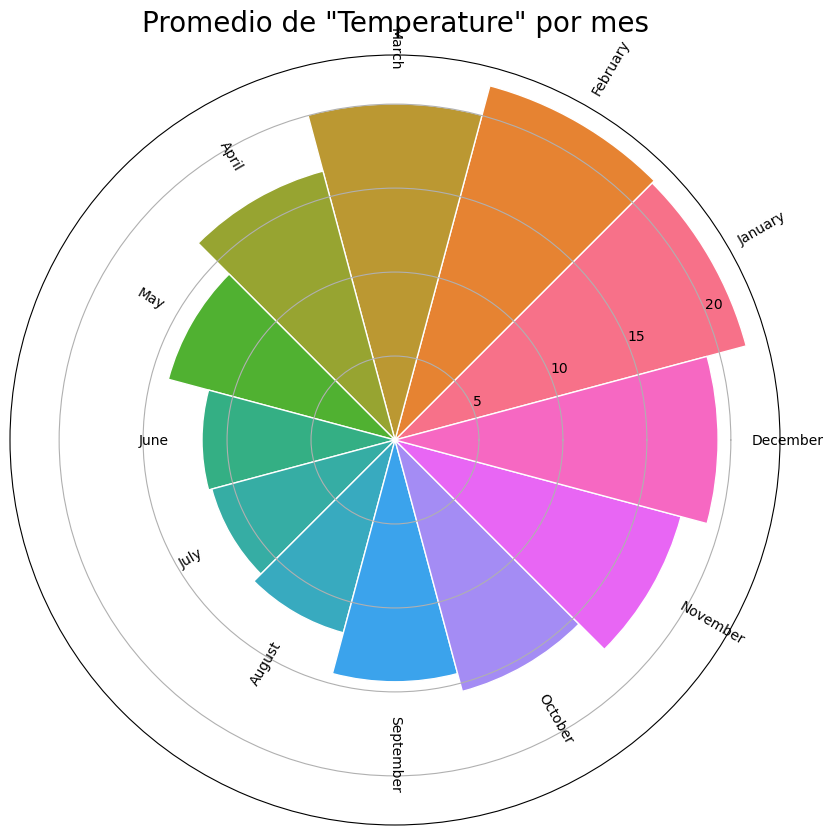

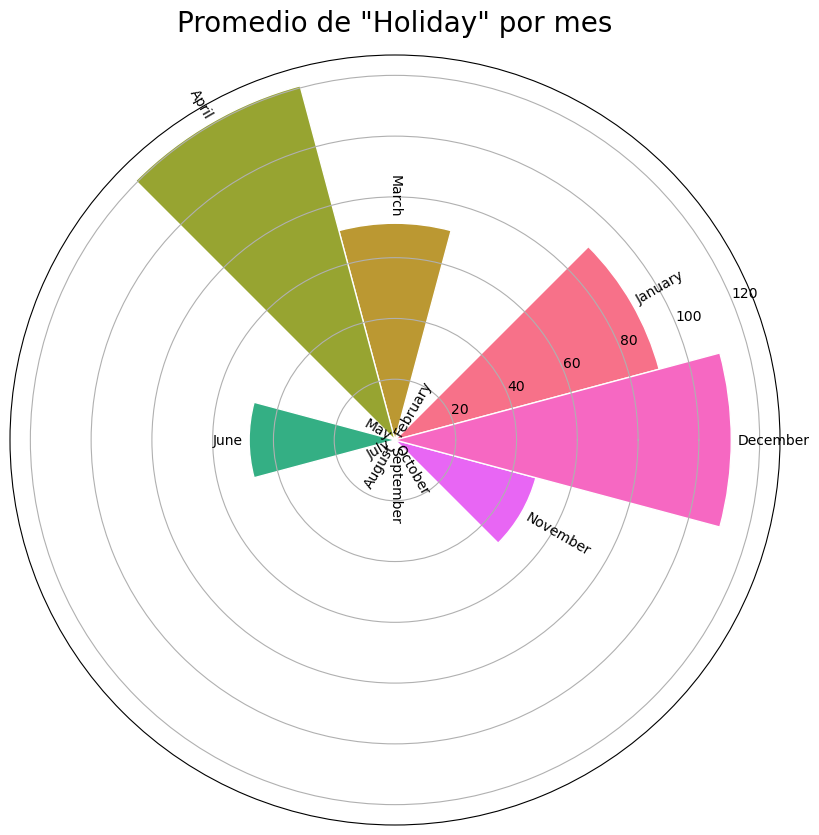

In [14]:
vic_circular_radial_graph = []

for col in df_vic_grouped.columns:
    circular_radial_graph(
        f'Promedio de "{col}" por mes', df_vic_grouped, col)
    plt.savefig(f'./images/{col}_circular_radial_graph.png')
    vic_circular_radial_graph.append(
        f'./images/vic_{col}_circular_radial_graph.png')
    plt.show()

Y las conclusiones que podemos obtener gracias a estos gráficos son exactamente las mismas vistas anteriormente.


#### 3.3.5. Conclusión de la visualización


Habiendo visto todos los gráficos mencionados (radar, barra circular y ploteo radial), entonces pudimos notar cómo el que nos fue de mayor utilidad y el que nos proveyó mayor y mejor información visual fue el **gráfico de radar**, porque nos permitió graficar en conjunto los porcentajes de las tres variables y poder ver en un mismo diagrama las fluctuaciones de estas por mes.

La imagen con todos los gráficos realizados se crea a continuación:


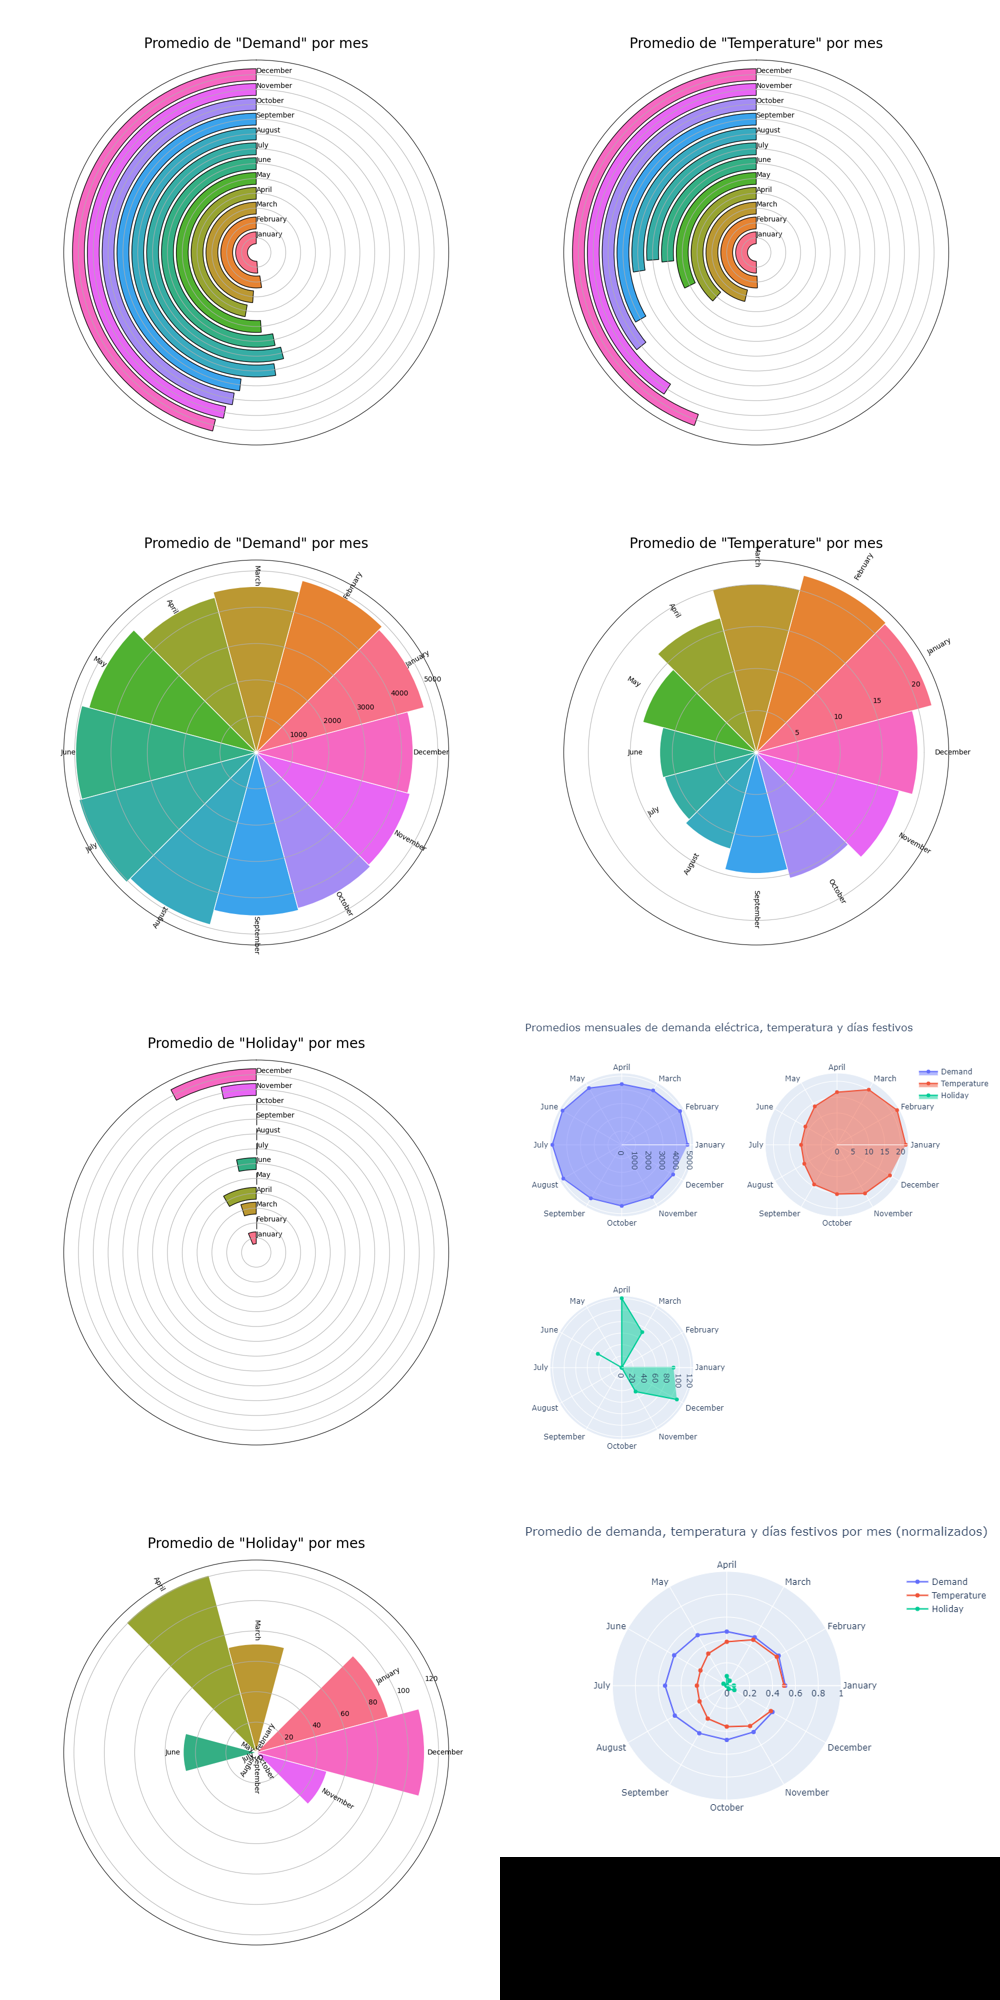

In [15]:
def get_collage(cols_n, rows_n, width, height, input_sname, save_name):
    c_width = width // cols_n
    c_height = height // rows_n
    size = c_width, c_height
    new_im = Image.new('RGB', (width, height))
    ims = []
    for p in input_sname:
        im = Image.open(p)
        im.thumbnail(size)
        ims.append(im)
    i, x, y = 0, 0, 0
    for col in range(cols_n):
        for row in range(rows_n):
            new_im.paste(ims[i], (x, y))
            i += 1
            y += c_height
        x += c_width
        y = 0
    new_im.save(save_name)


vic_image_names = [
    './images/Demand_circular_bar_graph.png',
    './images/Demand_circular_radial_graph.png',
    './images/Holiday_circular_bar_graph.png',
    './images/Holiday_circular_radial_graph.png',
    './images/Temperature_circular_bar_graph.png',
    './images/Temperature_circular_radial_graph.png',
    './images/vic_radar_graph.png',
    './images/vic_radar_graph_transformed.png'
]

get_collage(2, 4, 1000, 2000, vic_image_names, './images/vic_collage.png')
Image.open('./images/vic_collage.png')

Y, con ello, concluimos el primer problema planteado para este trabajo de Media Materia.


## 4. Polución en Madrid


### 4.1. Carga y descripción de los datos


Tenemos el dataset que contiene los datos acerca de la polución del aire de Madrid durante los años 2001 y 2018.

Este dataset contiene datos de mediciones de partículas a lo largo del tiempo pero de diferentes estaciones. Todas las estaciones no tienen el mismo equipo, por lo que cada una puede medir solo un cierto subconjunto de las partículas.

Teniendo esto en cuenta, vamos a considerar trabajar con todos los valores obtenidos haciendo la media de las mediciones de todas las estaciones en el mismo tiempo.

Respecto a las columnas que se consideran, tenemos:

- `date`: año, mes, día y hora de la medición realizada
- `station`: número de la estación donde se hizo la medición
- Tamaño de partículas:
  - `PM25`: partículas menores de 2,5 μm, medida en μg/m³
  - `PM10`: partículas menores de 10 μm
- Nivel de presencia de ciertas partículas:
  - `BEN`: nivel de benceno medido en μg/m³
  - `CO`: nivel de monóxido de carbono medido en mg/m³
  - `EBE`: nivel de etilbenceno medido en μg/m³
  - `MXY`: Nivel de m-xileno medido en μg/m³
  - `NMHC`: nivel de hidrocarburos no metánicos (compuestos orgánicos volátiles) medido en mg/m³
  - `NO_2`: nivel de dióxido de nitrógeno medido en μg/m³
  - `NOx`: nivel de óxidos nitrosos medido en μg/m³
  - `OXY`: nivel de o-xileno medido en μg/m³
  - `O_3`: nivel de ozono medido en μg/m³
  - `PXY`: Nivel de p-xileno medido en μg/m³
  - `SO_2`: nivel de dióxido de azufre medido en μg/m³
  - `TCH`: nivel total de hidrocarburos medido en mg/m³
  - `TOL`: nivel de tolueno (metilbenceno) medido en μg/m³
  - `NO`: nivel de óxido nítrico medido en μg/m³
  - `CH4`: nivel de metano medido en mg/m³

Con todo esto en consideración, podemos ya cargar los datos:


In [16]:
path = 'data/csvs_per_year/csvs_per_year'
files = [os.path.join(path, file)
         for file in os.listdir(path) if file.endswith('.csv')]
MADRID_POLUTION = pd.concat((pd.read_csv(file) for file in files), sort=False)

MADRID_POLUTION.head()

date  BEN    CO   EBE  MXY  NMHC       NO_2        NOx  \
0  2001-08-01 01:00:00  NaN  0.37   NaN  NaN   NaN  58.400002  87.150002   
1  2001-08-01 01:00:00  1.5  0.34  1.49  4.1  0.07  56.250000  75.169998   
2  2001-08-01 01:00:00  NaN  0.28   NaN  NaN   NaN  50.660000  61.380001   
3  2001-08-01 01:00:00  NaN  0.47   NaN  NaN   NaN  69.790001  73.449997   
4  2001-08-01 01:00:00  NaN  0.39   NaN  NaN   NaN  22.830000  24.799999   

    OXY        O_3        PM10   PXY  SO_2   TCH    TOL   station  PM25  NO  \
0   NaN  34.529999  105.000000   NaN  6.34   NaN    NaN  28079001   NaN NaN   
1  2.11  42.160000  100.599998  1.73  8.11  1.24  10.82  28079035   NaN NaN   
2   NaN  46.310001  100.099998   NaN  7.85   NaN    NaN  28079003   NaN NaN   
3   NaN  40.650002   69.779999   NaN  6.46   NaN    NaN  28079004   NaN NaN   
4   NaN  66.309998   75.180000   NaN  8.80   NaN    NaN  28079039   NaN NaN   

   CH4  
0  NaN  
1  NaN  
2  NaN  
3  NaN  
4  NaN

### 4.2. Transformación primaria de los datos


Para este punto debemos considerar varios factores:

- `date` debe estar en formato fecha.
- Los datos están tomados cada una hora.
- No consideraremos los valores obtenidos por cada estación de forma separada, sino que tomaremos en cuenta la media de todas las mediciones hechas en un tiempo en específico por las estaciones que midan esa partícula.
- Agruparemos, además, los datos de forma mensual.
- Consideraremos únicamente las partículas `NO_2` y `CO` dado que esas son las utilizadas para los _Problemas 2 y 3_ de este entregable.

Con todo esto en consideración, procedemos a hacer las transformaciones necesarias:


In [17]:
madrid = MADRID_POLUTION.copy()

# Convertimos a formato fecha
madrid['date'] = pd.to_datetime(madrid['date'], format='%Y-%m-%d %H:%M:%S')

# Agrupamos por fecha y calculamos la media
madrid = madrid.groupby('date').mean()
madrid = madrid.resample('M').mean()

# Nos quedamos con los valores de NO_2 y CO
madrid = madrid[['NO_2', 'CO']]

# Mostramos primeros y últimos registros
print('=========== Primeros registros ===========')
display(madrid.head())
print('=========== Últimos registros ===========')
display(madrid.tail())

=========== Primeros registros ===========


NO_2        CO
date                           
2001-01-31  57.026588  1.157704
2001-02-28  64.654926  1.231877
2001-03-31  49.401208  0.834881
2001-04-30  53.098803  0.685284
2001-05-31  64.109276  0.773770

=========== Últimos registros ===========


NO_2        CO
date                           
2018-01-31  48.570821  0.413898
2018-02-28  45.923543  0.390074
2018-03-31  29.501152  0.291500
2018-04-30  31.076017  0.284760
2018-05-31  29.125000  0.250000

### 4.3. Descomposición de las mediciones _(Problema 2)_


#### 4.3.1. Primera vista y funciones auxiliares


En el presente problema lo que se procura es realizar la descomposición en tendencia y estacionalidad aditiva y multiplicativa para las medidas de polución de los gases de Madrid `NO_2` y `CO`.

Por ello mismo, primero miremos cómo se distribuye a lo largo de los meses las mediciones obtenidas para cada uno:


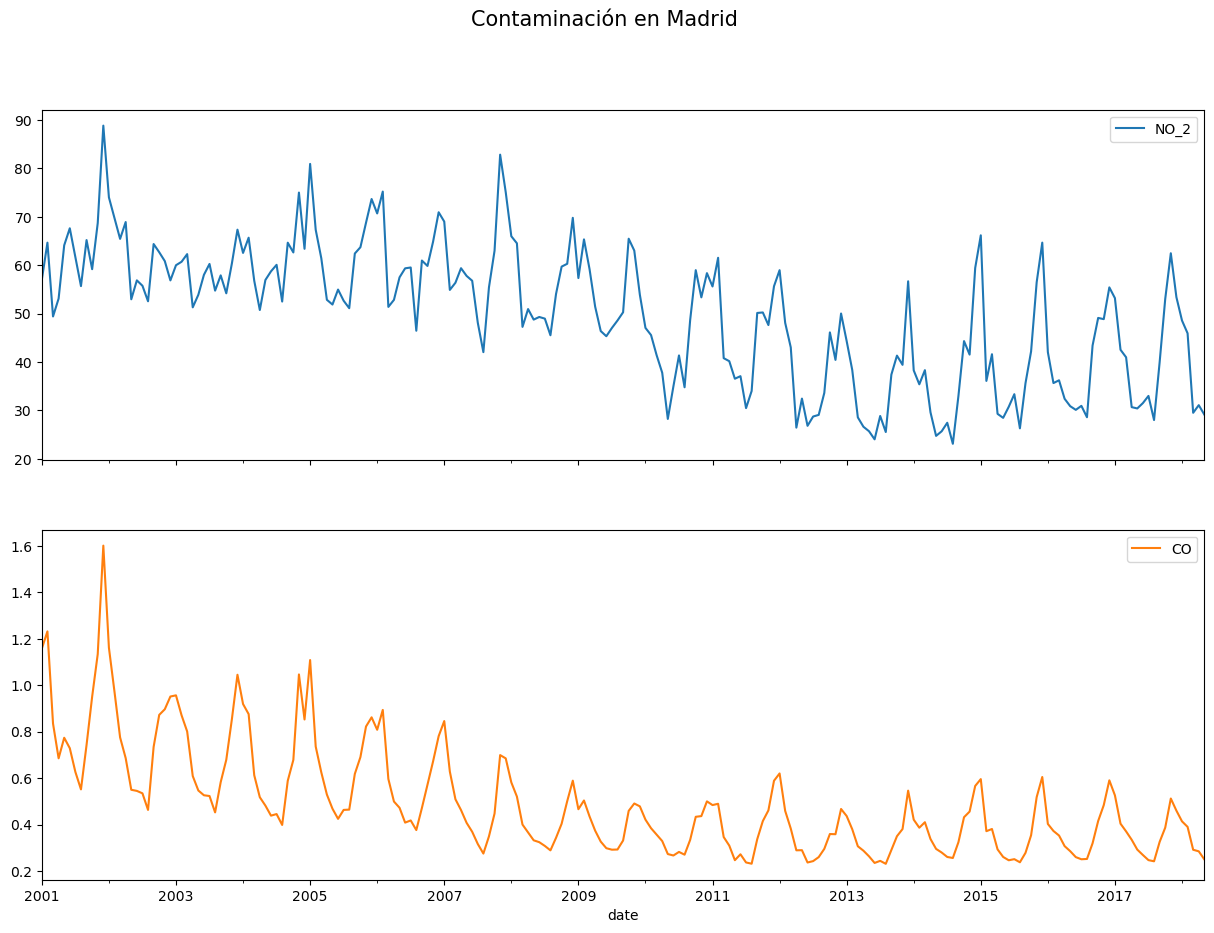

In [18]:
madrid.plot(subplots=True, figsize=(15, 10))
plt.suptitle('Contaminación en Madrid', fontsize=15)
plt.show()

Analizando los gráficos es donde podemos notar que las tendencias de las mediciones de ambos gases disminuye a lo largo del tiempo, mientras que también podemos observar que existe una clara estacionalidad debido a la presencia de picos y valles de forma constante y algo uniforme.

Además, otro factor a tener en cuenta es la magnitud de los picos y los valles, ya que esto nos indica si se adapta mejor una descomposición aditiva o multiplicativa. Por ello, podemos ver que:

- Para `NO_2` tenemos algo uniforme la magnitud de los picos, sin tanta diferencia al inicio con el final, por lo que el modelo aditivo podría plantear mejores resultados.
- Para `CO` sucede lo contrario dado que a medida que avanza el tiempo los picos son cada vez menores, lo que nos indica que un modelo multiplicativo podría adaptarse mucho mejor.

Por esto mismo, podemos usar las siguientes funciones auxiliares para descomponer nuestras series temporales y analizar de forma más detallada y precisa el comportamiento:


In [19]:
def show_seasonal_descompose(df, col):
    seasonal_additive = seasonal_decompose(df[col], model='additive')
    seasonal_multiplicative = seasonal_decompose(
        df[col], model='multiplicative')

    fig_add, fig_mult = seasonal_additive.plot(), seasonal_multiplicative.plot()

    fig_add.suptitle(f'Descomposición aditiva de {col}', fontsize=25)
    fig_mult.suptitle(f'Descomposición multiplicativa de {col}', fontsize=25)

    fig_add.set_figheight(10), fig_add.set_figwidth(15)
    fig_mult.set_figheight(10), fig_mult.set_figwidth(15)

    fig_add.get_children()[1].set_title('')
    fig_mult.get_children()[1].set_title('')

    plt.show()


def show_seasonal_descompose_together(df, col):
    # Aditivo
    seasonal_additive = seasonal_decompose(df[col], model='additive')

    fig = plt.figure(figsize=(15, 7))
    plt.plot(df[col], label='Original', color='blue')
    plt.plot(seasonal_additive.trend, label='Tendencia', color='green')
    plt.plot(seasonal_additive.seasonal, label='Estacionalidad', color='red')
    for year in range(2001, 2019):
        plt.axvline(x=pd.to_datetime(str(year) + '-06-01'), color='black')

    plt.plot(seasonal_additive.resid, label='Residuo', color='purple')

    fig.suptitle(f'Descomposición aditiva de {col}', fontsize=25)
    plt.legend()

    # Multiplicativo
    seasonal_multiplicative = seasonal_decompose(
        df[col], model='multiplicative')

    fig = plt.figure(figsize=(15, 7))
    plt.plot(df[col], label='Original', color='blue')
    plt.plot(seasonal_multiplicative.trend, label='Tendencia', color='green')
    plt.plot(seasonal_multiplicative.seasonal,
             label='Estacionalidad', color='red')
    for year in range(2001, 2019):
        plt.axvline(x=pd.to_datetime(str(year) + '-06-01'), color='black')

    plt.plot(seasonal_multiplicative.resid, label='Residuo', color='purple')

    fig.suptitle(f'Descomposición multiplicativa de {col}', fontsize=25)
    plt.legend()

    plt.show()

#### 4.3.2. Descomposición mensual de `NO_2`


Con esto, miremos la descomposición de las mediciones mensuales de cada uno de los gases. Comencemos con `NO_2`:


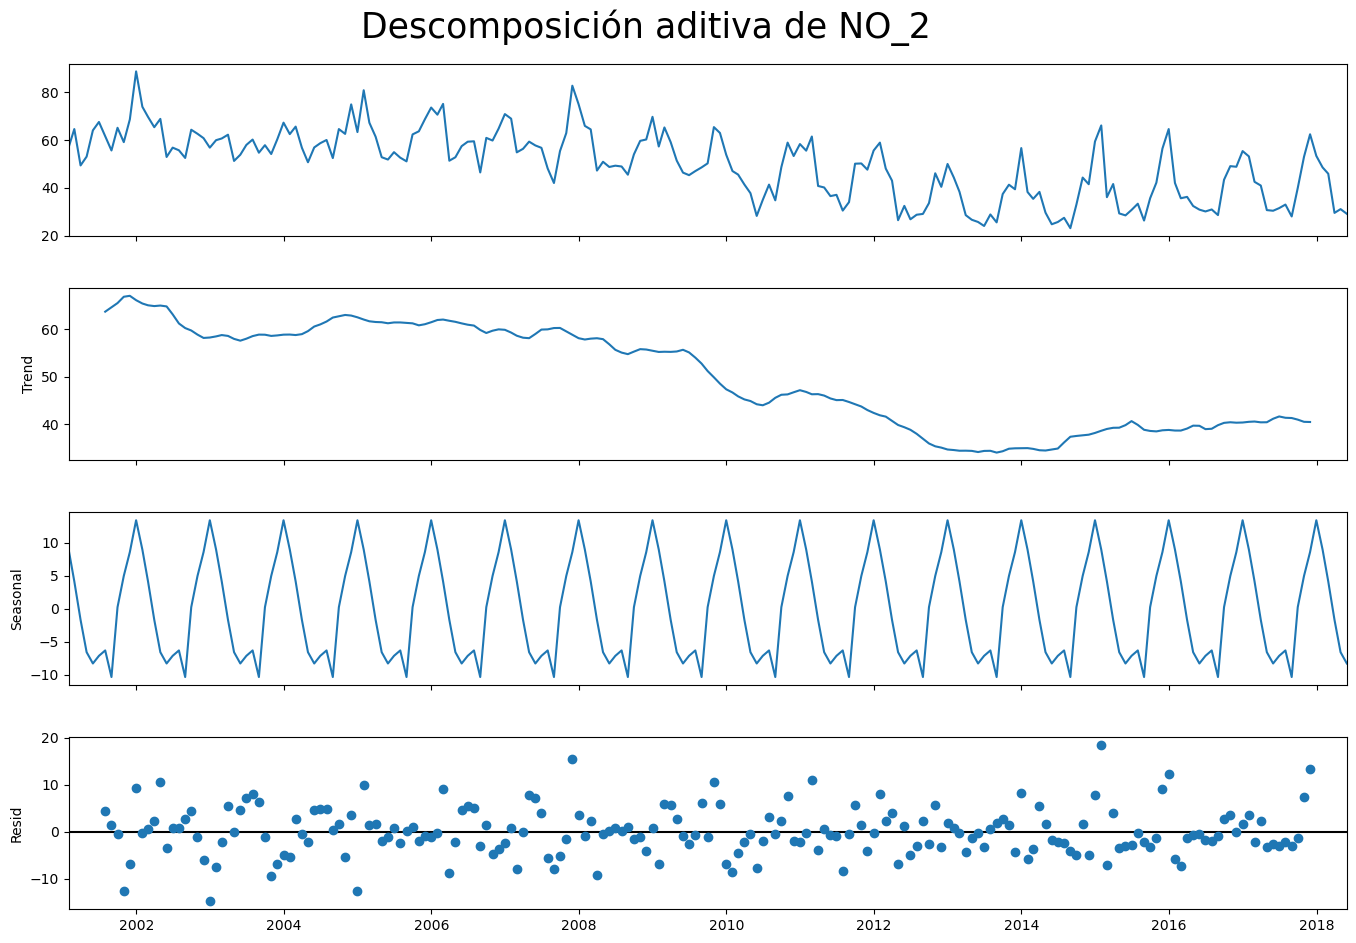

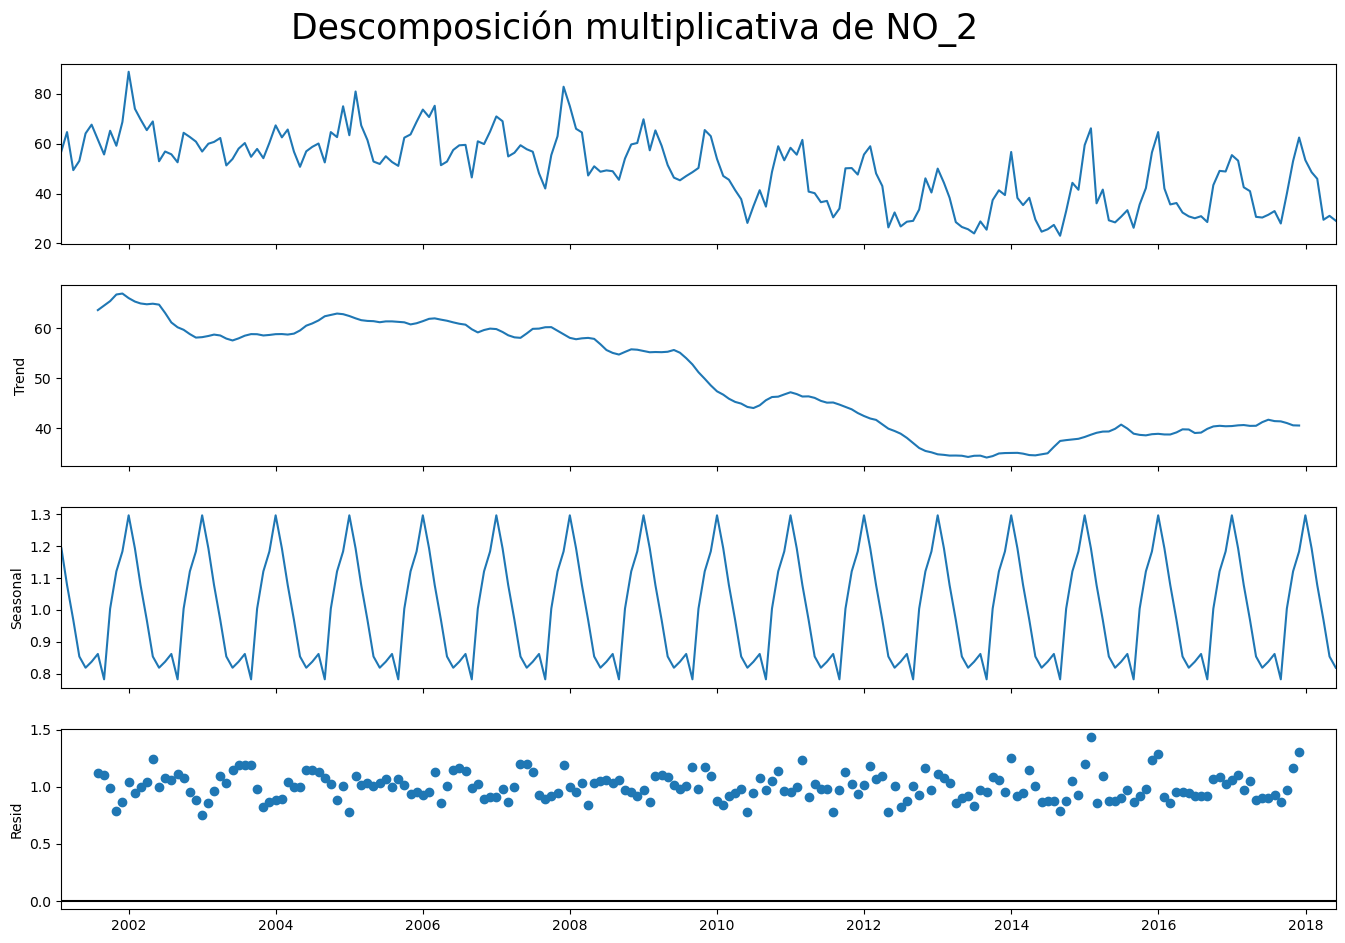

In [20]:
show_seasonal_descompose(madrid, 'NO_2')

Gracias a lo cual se nota claramente la tendencia de disminución de los niveles de `NO_2` a lo largo del tiempo y la presencia de los picos a finales e inicios de cada año (se podrá ver de mejor modo a continuación).

Para mayor precisión en la observación, podemos ver la descomposición graficada en conjunto con la serie temporal original para ambos casos:


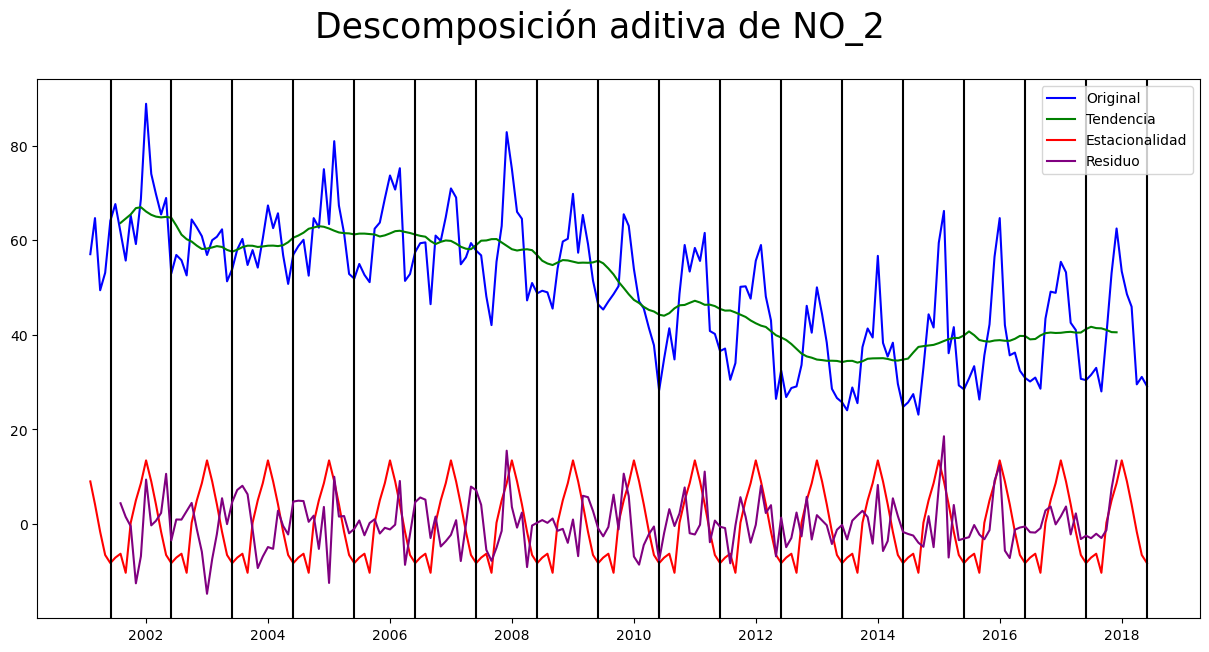

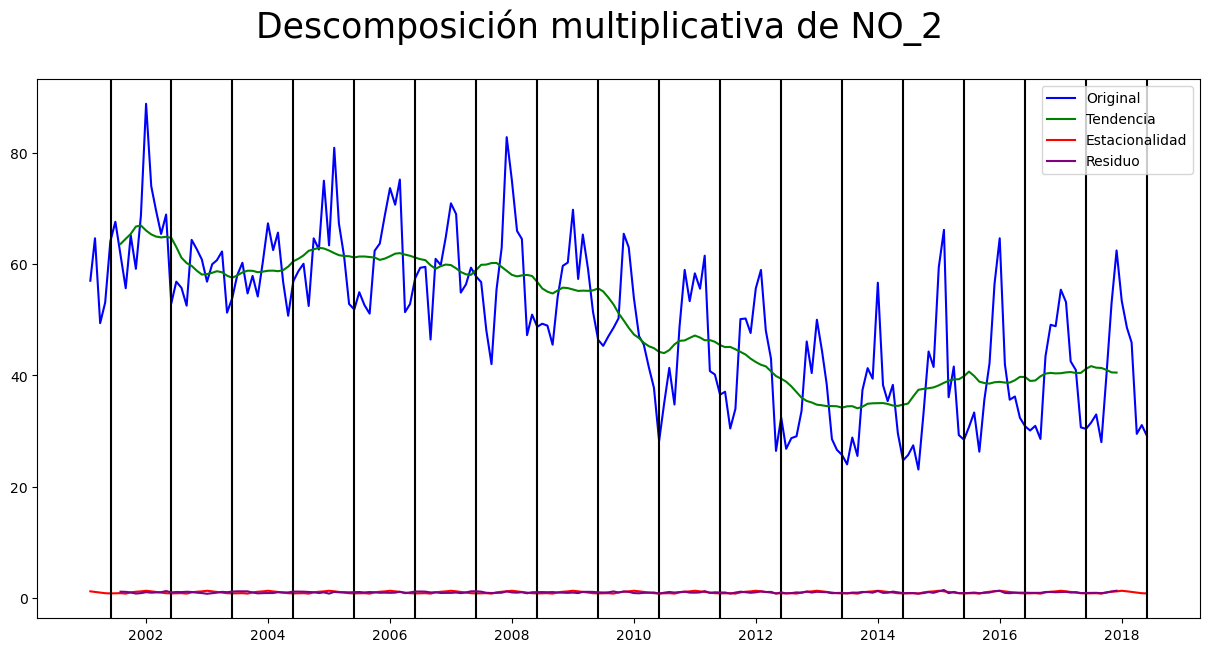

In [21]:
show_seasonal_descompose_together(madrid, 'NO_2')

#### 4.3.3. Descomposición mensual de `CO`


Ahora, si queremos prestar atención a la descomposición de las mediciones de `CO` a lo largo del tiempo, tenemos:


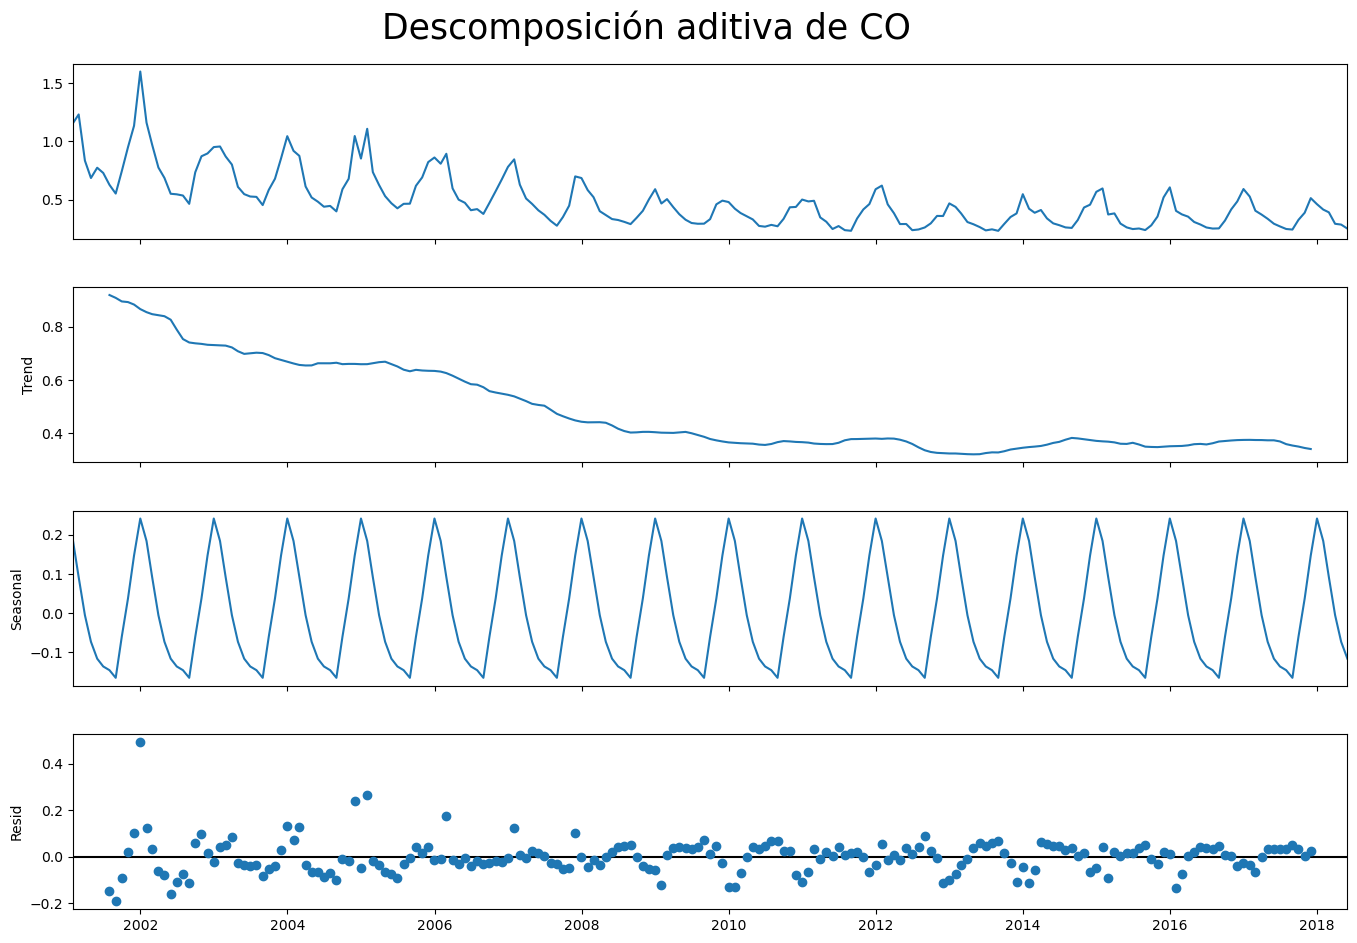

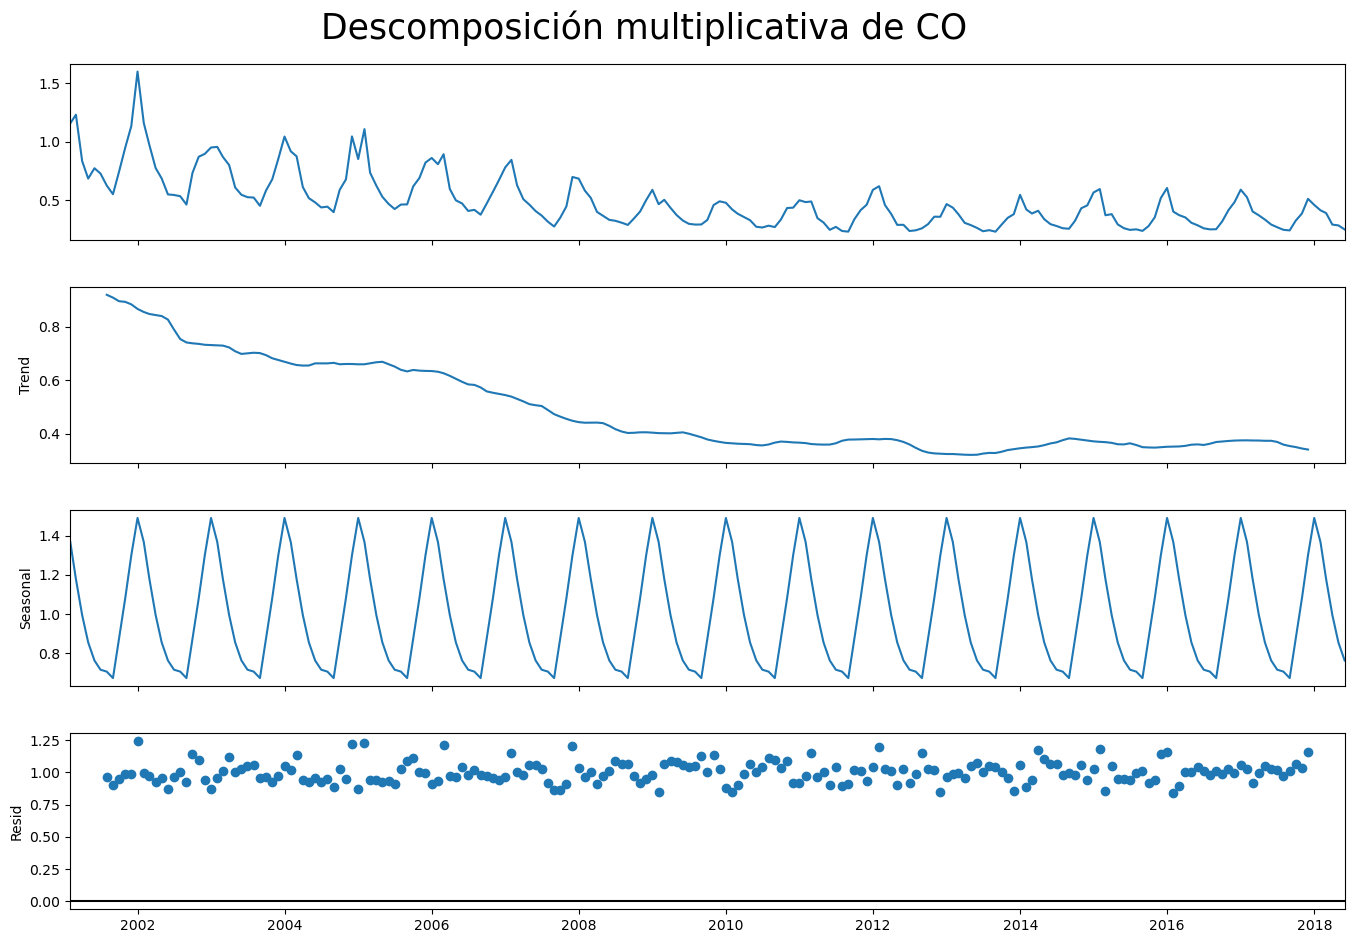

In [22]:
show_seasonal_descompose(madrid, 'CO')

Gracias a lo cual observamos también una tendencia de disminución de nivel, aunque mucho más intensa en los primeros años y prolongada y estable en los finales. Otro factor, además, a tener en cuenta es que, al igual que con `NO_2`, la presencia de los picos de nivel en las mediciones se dan entre finales y principios de año. Esto último lo podemos ver en los gráficos en conjunto:


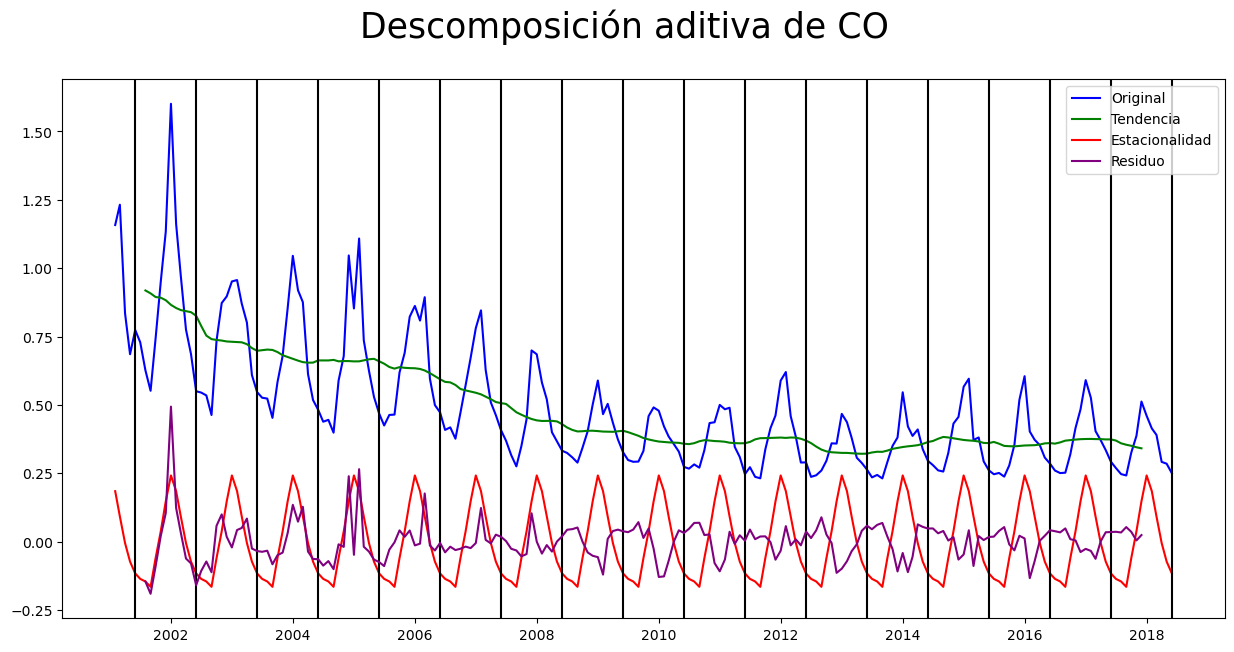

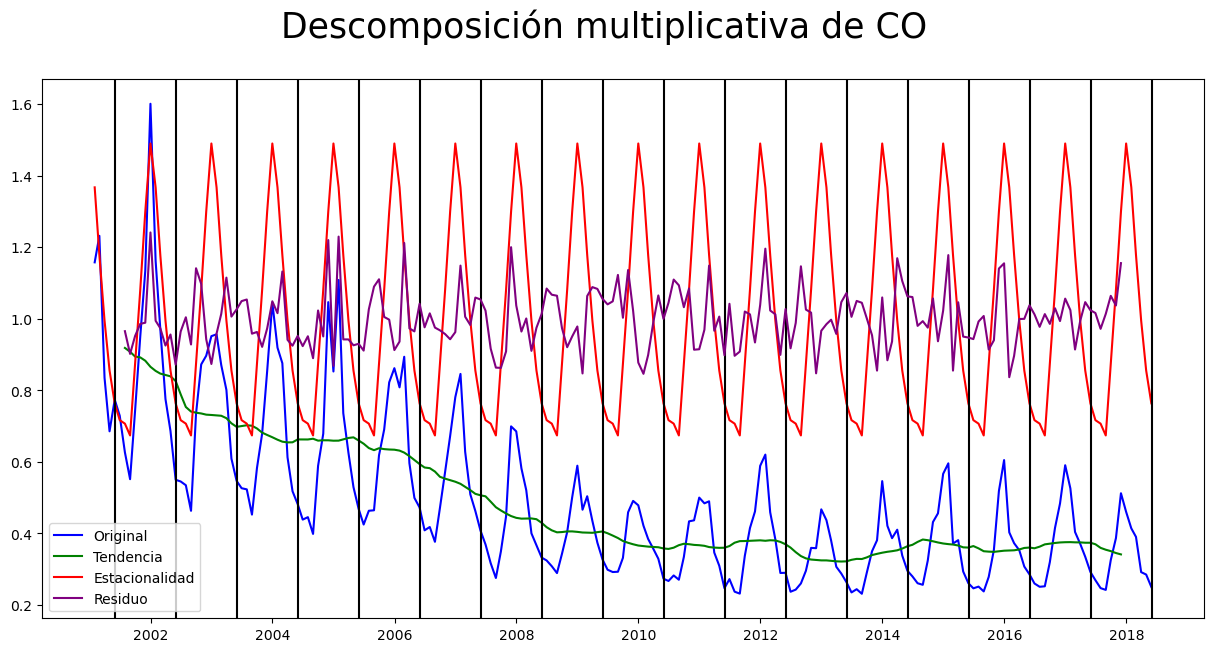

In [23]:
show_seasonal_descompose_together(madrid, 'CO')

#### 4.3.4. Conclusiones de la descomposición


Motivo de ello, podemos observar como _conclusión_ que:

- Tanto `NO_2` como `CO` tienen una tendencia de disminución de nivel de presencia.
- Los picos de nivel en ambos casos corresponden a final/principio de año.
- El modelo de descomposición que mejor se adapta para `NO_2` es el aditivo, mientras que para `CO` es el multiplicativo. Esto se da ya que el primero mantiene las magnitudes de sus picos, mientras que el segundo no (cada vez van siendo menores).


### 4.4. Suavizado y predicción del comportamiento de los gases (_Problema 3_)


Ahora, ya habiendo analizado el comportamiento de las series temporales de las mediciones de nivel de presencia de `NO_2` y `CO` en el aire de Madrid durante el período 2001-2018, lo que vamos a hacer es suavizar las series y predecir el comportamiento de los gases para cada uno de los suavizados.

Lo primero que vamos a hacer es generar los tres suavizados:

- Exponencial: Considera únicamente el _nivel_
- Holt: Considera _nivel_ y _tendencia_
- Holt-Winter: Considera _nivel_, _tendencia_ y _estacionalidad_

Y luego predecir usando toda la serie, dando las conclusiones según lo observado.


#### 4.4.1. Funciones auxiliares a utilizar


Para ello, vamos a hacer uso de las siguientes funciones auxiliares para encontrar los mejores parámetros posibles de los suavizamientos en base al MSE:


In [24]:
def search_best_smoothing_parameters(data):
    # Simple Exponential Smoothing
    ses = SimpleExpSmoothing(data).fit()
    ses_best_mse = round(ses.sse/len(ses.fittedvalues), 10)
    ses_best_params = {'initialization_method': 'estimated'}

    print('=========== Simple Exponential Smoothing ===========')
    print(f'Best params: {ses_best_params}')
    print(f'Best MSE: {ses_best_mse}')

    # Holt Exponential Smoothing
    holt_params = {
        'trend': ['add', 'mul', 'additive', 'multiplicative'],
        'damped_trend': [True, False],
        'use_boxcox': [True, False],
    }
    holt_grid = ParameterGrid(holt_params)

    holt_best_mse = np.inf
    holt_best_params = None
    for p in holt_grid:
        holt = ExponentialSmoothing(
            data, trend=p['trend'], damped_trend=p['damped_trend'], use_boxcox=p['use_boxcox']).fit()
        mse = round(holt.sse/len(holt.fittedvalues), 10)

        if mse < holt_best_mse:
            holt_best_mse = mse
            holt_best_params = p

    print('=========== Holt Exponential Smoothing ===========')
    print(f'Best params: {holt_best_params}')
    print(f'Best MSE: {holt_best_mse}')

    # Holt-Winter Exponential Smoothing
    holt_winter_params = {
        'trend': ['add', 'mul', 'additive', 'multiplicative'],
        'damped_trend': [True, False],
        'seasonal': ['add', 'mul', 'additive', 'multiplicative'],
        'use_boxcox': [True, False],
    }
    holt_winter_grid = ParameterGrid(holt_winter_params)

    holt_winter_best_mse = np.inf
    holt_winter_best_params = None
    for p in holt_winter_grid:
        holt_winter = ExponentialSmoothing(

            data, trend=p['trend'], damped_trend=p['damped_trend'], seasonal=p['seasonal'], use_boxcox=p['use_boxcox']).fit()
        mse = round(holt_winter.sse/len(holt_winter.fittedvalues), 10)

        if mse < holt_winter_best_mse:
            holt_winter_best_mse = mse
            holt_winter_best_params = p

    print('=========== Holt-Winter Exponential Smoothing ===========')
    print(f'Best params: {holt_winter_best_params}')
    print(f'Best MSE: {holt_winter_best_mse}')

    return ses_best_params, holt_best_params, holt_winter_best_params

Además, consideraremos las siguientes funciones auxiliares para plotear los mejores suavizados, su comparación, distribución de los datos y predicción:


In [25]:
def plot_smoothing(data, ses, holt, holt_winter, forecast_steps=36):
    fig = plt.figure(figsize=(15, 7))

    plt.plot(data, label='Original', color='blue')

    plt.plot(ses.fittedvalues, label='Simple exponential smoothing', color='green')
    plt.plot(holt.fittedvalues, label='Holt exponential smoothing', color='red')
    plt.plot(holt_winter.fittedvalues,
             label='Holt-Winter exponential smoothing', color='purple')

    plt.plot(ses.forecast(forecast_steps),
             label='Simple exponential smoothing forecast', color='green', linestyle='--')
    plt.plot(holt.forecast(forecast_steps),
             label='Holt exponential smoothing forecast', color='red', linestyle='--')
    plt.plot(holt_winter.forecast(forecast_steps),
             label='Holt-Winter exponential smoothing forecast', color='purple', linestyle='--')

    fig.suptitle(f'Suavizados exponenciales para {data.name}', fontsize=25)
    plt.legend()

    plt.show()


def show_data_distribution(data, ses, holt, holt_winter):
    fig = plt.figure(figsize=(15, 7))

    ses.fittedvalues.plot(
        kind='kde', label='Simple exponential smoothing', color='green')
    holt.fittedvalues.plot(
        kind='kde', label='Holt exponential smoothing', color='red')
    holt_winter.fittedvalues.plot(kind='kde',
                                  label='Holt-Winter exponential smoothing', color='purple')

    data.plot(kind='kde', label='Original', color='blue')

    fig.suptitle(f'Distribución de los datos de los suavizados para {
                 data.name}', fontsize=25)
    plt.legend()

    plt.show()


def do_smoothing(df, x, time_division, ses_params, holt_params, holt_winter_params, forecast_steps=36, show_distribution=True):
    train = df[:time_division][x]

    df_ses = SimpleExpSmoothing(train, **ses_params).fit()
    df_holt = ExponentialSmoothing(train, **holt_params).fit()
    df_holt_winter = ExponentialSmoothing(train, **holt_winter_params).fit()

    plot_smoothing(df[x], df_ses, df_holt, df_holt_winter, forecast_steps)
    if show_distribution:
        show_data_distribution(df[x], df_ses, df_holt, df_holt_winter)

#### 4.4.2. Suavizado con el entrenamiento y predicción del test para `NO_2`


Ya teniendo en cuenta las funciones anteriormente mencionadas, podemos proceder con el cálculo y la búsqueda de los mejores suavizados posibles para nuestras series de tiempo de mediciones del nivel de presencia de los diferentes gases a considerar (`NO_2` y `CO`). Para ello, vamos a tomar en cuenta la fecha `2015-06-01` como _corte_ de división para el dataset de _training_ y de _test_. La idea va a ser obtener los parámetros óptimos en base a los datos de entrenamiento y chequear su efectividad y bondad comparando con el período de test (mediados de 2015 a 2018).

Teniendo todo esto en cuenta, vamos a analizar el comportamiento y suavizado de `NO_2`:


======================== NO_2 ========================
=========== Simple Exponential Smoothing ===========
Best params: {'initialization_method': 'estimated'}
Best MSE: 67.9751959762
=========== Holt Exponential Smoothing ===========
Best params: {'damped_trend': False, 'trend': 'mul', 'use_boxcox': False}
Best MSE: 67.5010568181
=========== Holt-Winter Exponential Smoothing ===========
Best params: {'damped_trend': True, 'seasonal': 'add', 'trend': 'add', 'use_boxcox': True}
Best MSE: 34.2354615373


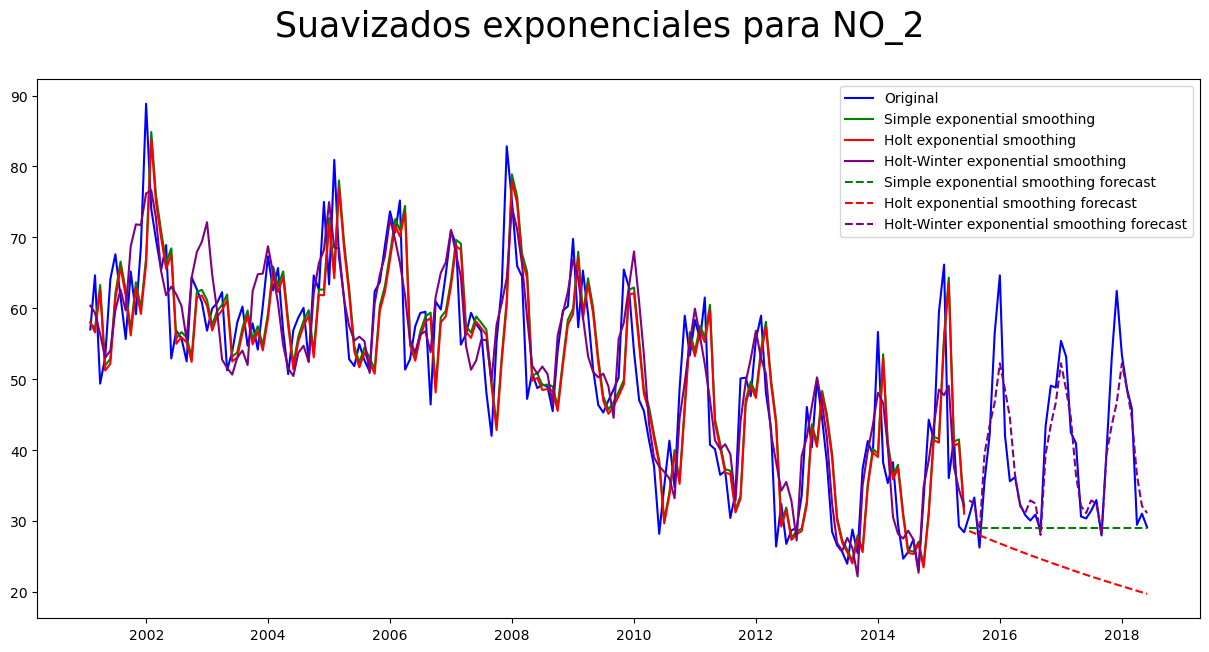

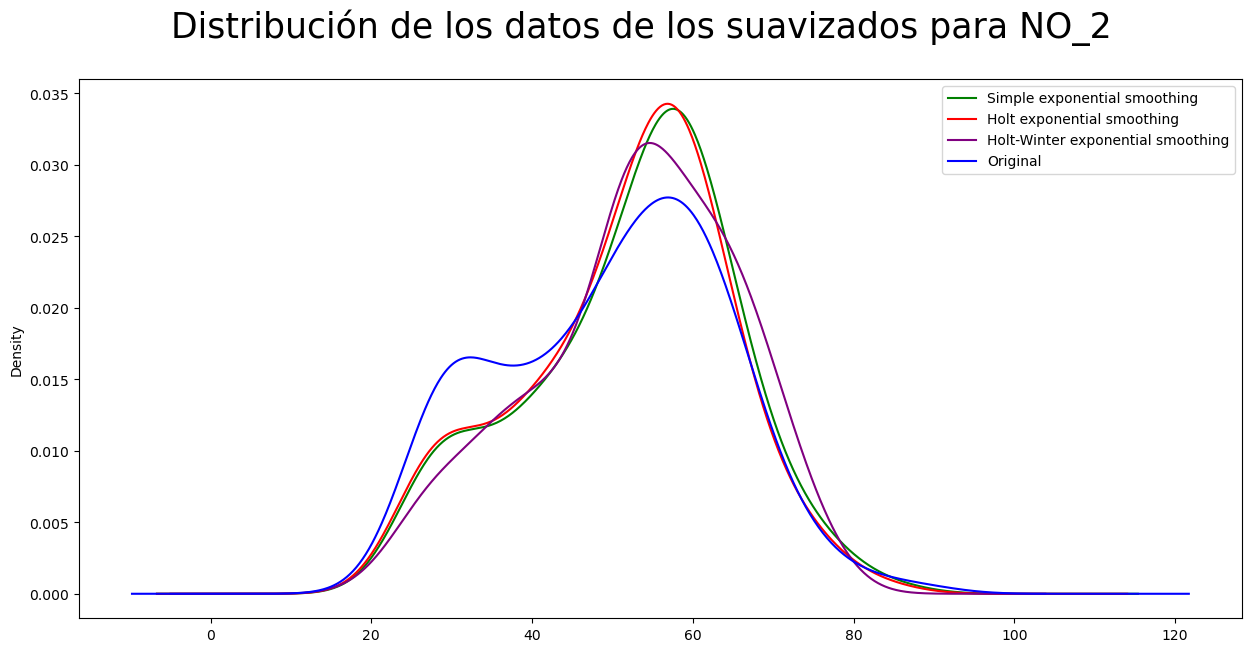

In [26]:
time_division = '2015-06-01'

# NO_2
print('======================== NO_2 ========================')
no2_params = search_best_smoothing_parameters(madrid[:time_division]['NO_2'])
do_smoothing(madrid, 'NO_2', time_division, *no2_params)

Con esto, podemos notar cómo se comporta cada uno de los suavizados y su predicción en función de la cantidad de características de la serie temporal a considerar:

- Vemos con el suavizado exponencial simple que considera solo el nivel siendo una línea horizontal.
- Vemos con Holt cómo es una recta con tendencia de disminución, como ya se pudo ver anteriormente gracias a la tendencia en la descomposición de la serie.
- Y vemos con Holt-Winter cómo se pretende replicar el mismo patrón de picos y valles gracias a la estacionalidad de la serie. Se nota que este es el mejor de todos porque considera la presencia de aumento de nivel a finales/inicios de año.

Además, podemos ver que es el mejor comparando los MSE dado que los valores obtenidos para el entrenamiento son los siguientes:

- Suavizado exponencial simple: $67.975$
- Holt: $67.501$
- Holt-Winter: $34.235$

Y, además, es algo que podemos ver que trata de _replicar_ y _ajustarse_ la distribución de los valores en el suavizado de Holt-Winter con la distribución original de estos.

Finalmente, respecto a la predicción, podemos notar que predice bien la tendencia, estacionalidad y nivel, mostrando exactamente la forma que van a tener los datos y realizando una predicción precisa aunque inexacta, dado que ajusta por valores inferiores a los reales (gracias a la fuerte tendencia de disminución marcada por el entrenamiento). Esto es: a finales/principios de año tenemos valores inexactos donde se predicen niveles inferiores de presencia de `NO_2` a los realmente obtenidos, por lo que estaríamos previendo menor polución a la real. Sin embargo, en las otras etapas de año ajusta bien a los valores y niveles reales y observados.

Por ello mismo, la predicción realizada es buena, pero siempre teniendo en cuenta que durante el período de picos (final/inicio de año) existe un margen de error a considerar porque probablemente la polución sea mayor a la prevista.


#### 4.4.3. Suavizado con el entrenamiento y predicción del test para `CO`


Ahora, vamos a hacer el mismo análisis de antes pero para `CO`:


======================== CO ========================
=========== Simple Exponential Smoothing ===========
Best params: {'initialization_method': 'estimated'}
Best MSE: 0.0139770869
=========== Holt Exponential Smoothing ===========
Best params: {'damped_trend': True, 'trend': 'mul', 'use_boxcox': False}
Best MSE: 0.0136059443
=========== Holt-Winter Exponential Smoothing ===========
Best params: {'damped_trend': False, 'seasonal': 'mul', 'trend': 'mul', 'use_boxcox': False}
Best MSE: 0.0036923978


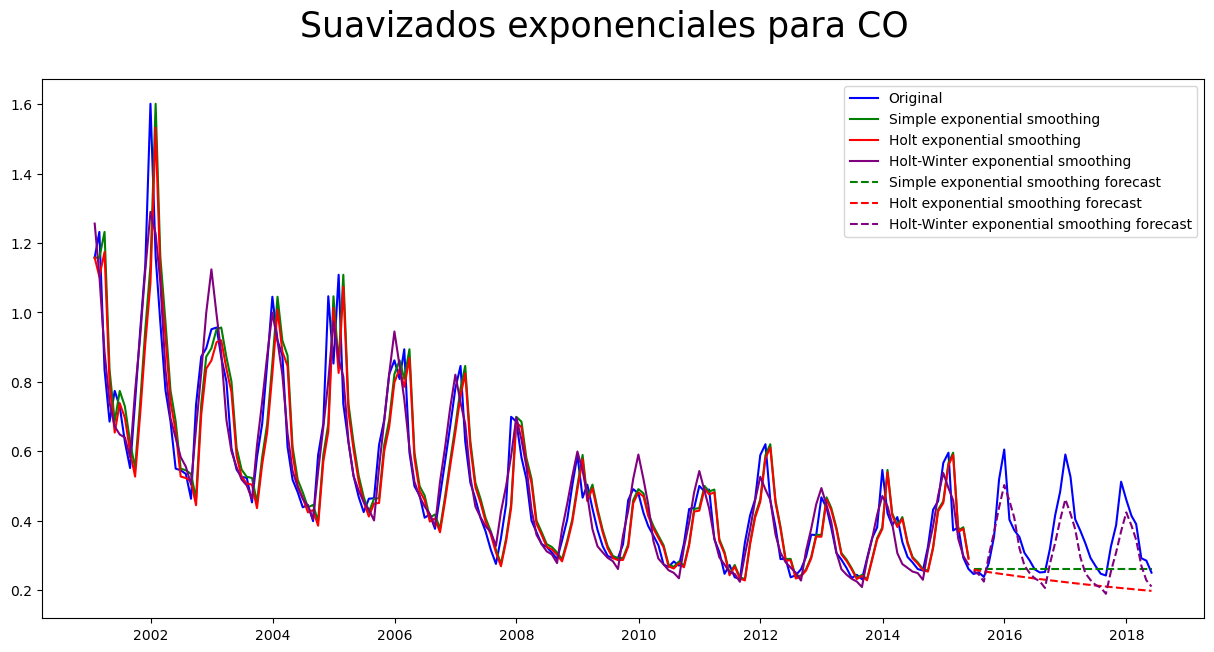

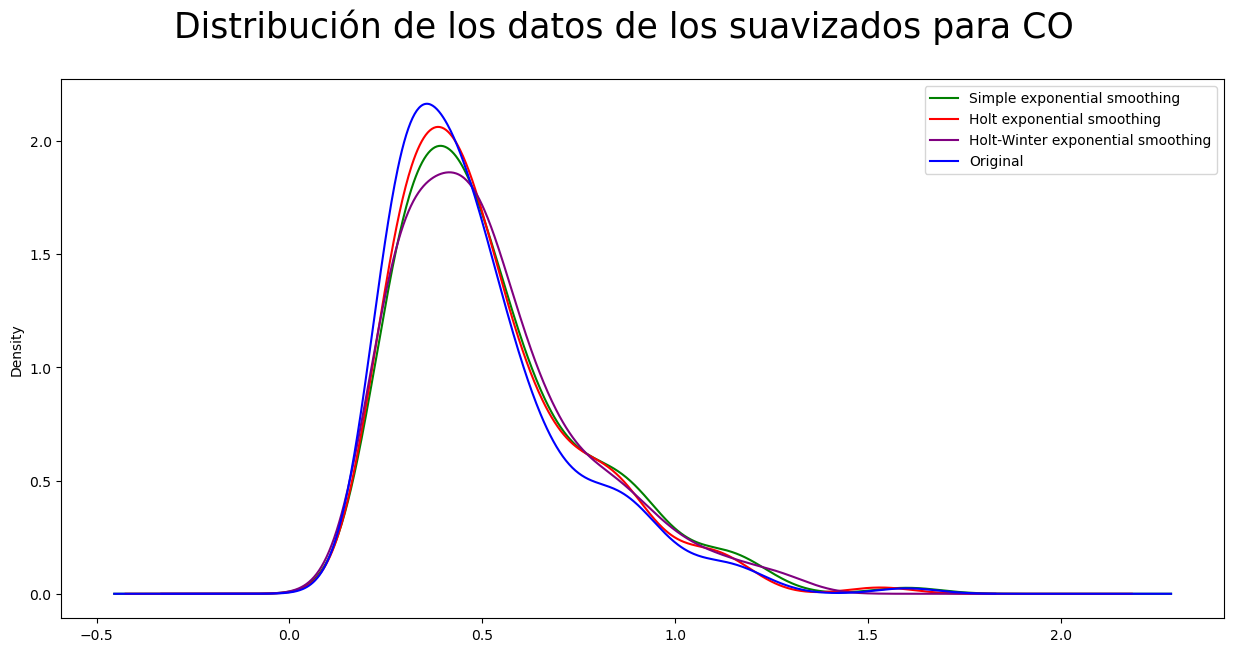

In [27]:
# CO
print('======================== CO ========================')
co_params = search_best_smoothing_parameters(madrid[:time_division]['CO'])
do_smoothing(madrid, 'CO', time_division, *co_params)

Con esto, podemos observar y notar, de forma similar que con `NO_2` que el que mejor se ajusta es, obviamente, Holt-Winter (con menor MSE, aprox. $0$) y que la predicción que realiza es acertada en los momentos donde no existe presencia de picos (inicio/final de año). Es decir, los valores de nivel de presencia de `CO` en el aire previstos son menores a los observados en los tiempos correspondientes a inicio/final de año. Sin embargo, en las demás fechas se ajusta bastante bien a los valores reales.

Esto último puede notarse claramente en la distribución de los valores originales vs los del suavizamiento con Holt-Winter dado que la diferencia entre los máximos de ambos es la más grande entre todos los suavizados considerados.

Por esto mismo, notamos que las conclusiones son similares a las de `NO_2` dado que se predice bien la tendencia, el nivel y la estacionalidad, pero con un margen de error a considerar en inicio/final de año.


#### 4.4.4. Predicción a futuro


Habiendo ya analizado el comportamiento de nuestras predicciones, vamos a ver qué depara a Madrid respecto a la polución del aire para los próximos años (considerando hasta $2030$ inclusive) y analizar cuáles son las implicancias de ello:


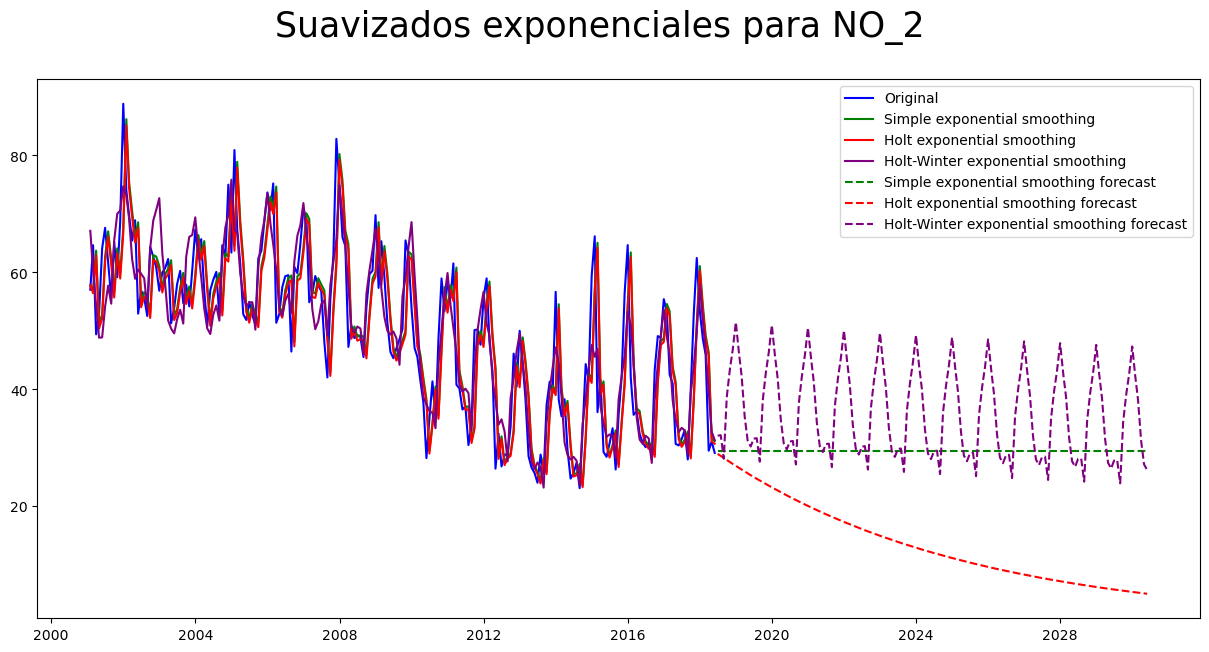

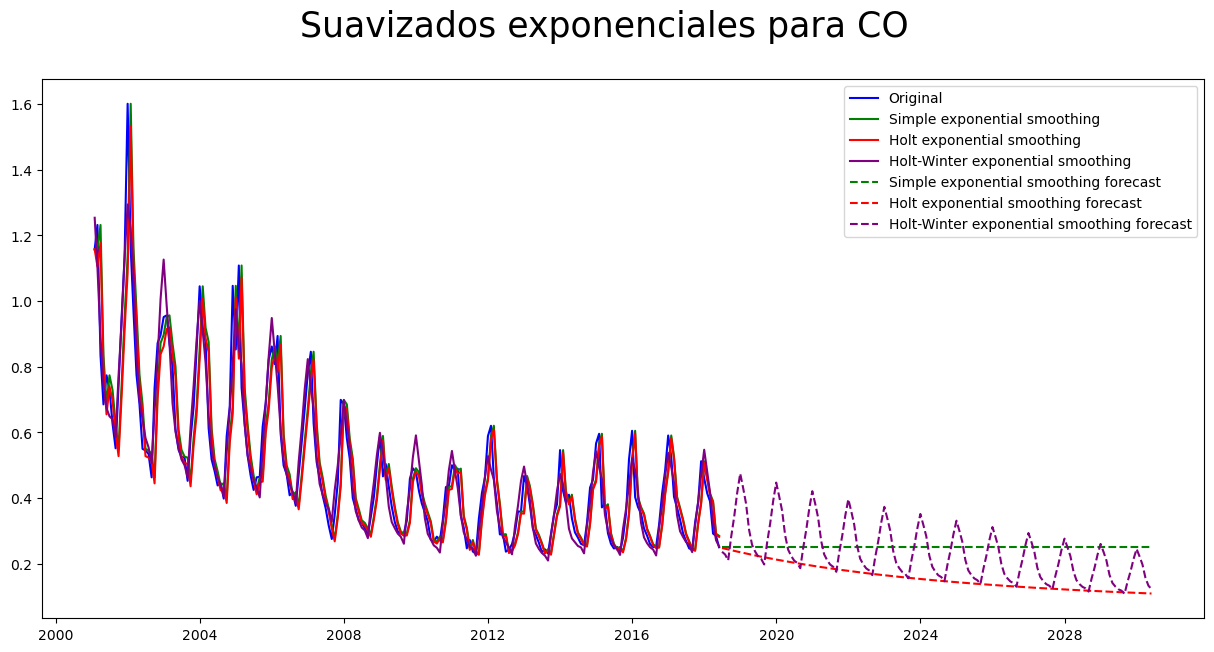

In [28]:
# NO_2
do_smoothing(madrid, 'NO_2', '2018-06-01', *no2_params,
             forecast_steps=12 * 12, show_distribution=False)

# CO
do_smoothing(madrid, 'CO', '2018-06-01', *co_params,
             forecast_steps=12 * 12, show_distribution=False)

Gracias a lo cual observamos una gran baja del nivel de presencia de `CO` en el aire de Madrid para $2030$, llegando incluso a estar bajo el nivel de la serie temporal analizada durante el período $2001-2018$. Se observa que cada vez y cada año los valores obtenidos son mucho menores, al igual que sus picos.

Ahora, respecto a `NO_2`, no observamos un cambio tan significativo (relativamente) si comparamos respecto al cambio de `CO`, dado que se mantiene bastante uniforme la magnitud de los valores y de los picos existentes. Por ello, se prevé una baja de presencia de `NO_2` en el aire de Madrid en $2030$ aunque no de forma significativa.


## 5. Conclusiones finales del trabajo


Gracias a todo el trabajo, los análisis y las predicciones realizadas tanto a los datos de _demanda eléctrica de Victoria_ como los de _polución en el aire en Madrid_, pudimos trabajar con los conceptos, métodos y herramientas más importantes para las series de tiempo. Como consecuencia de todo lo trabajado, se puede afinar y mostrar lo importante que es el análisis de los datos en las series temporales y la fuerza e importancia que estos pueden tener para la predicción del comportamiento de eventos o demandas en el futuro. Esto nos permite prepararnos para trabajar y predecir comportamientos de las acciones y de objetos financieros en el próximo trabajo final de la materia.
